<a href="https://colab.research.google.com/github/won-hj/2025_Capstone_Design/blob/master/Lecture3/%5BHW_3%5D_MLP_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EC%84%B1%EB%8A%A5%EC%97%90_%EC%98%81%ED%96%A5%EC%9D%84_%EC%A3%BC%EB%8A%94_%EC%9A%94%EC%86%8C%EB%B3%84_%EC%8B%A4%ED%97%98%EA%B3%BC_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title [HW#3] MLP 신경망 성능에 영향을 주는 요소별 실험과 분석
#
# 기한 : 2025년 5월 25일(일요일) 오후 23시 59분
#
# <평가기준>
# 1) 실험 정확성 및 재현성 20% : 실험 조건에 맞춰 정확하게 수행하고, 동일 조건에서 재현 가능한지 확인
#   - 동일한 조건에서 실험이 재현 가능한가?
#   - 학습률, 에폭 수, Optimizer 설정을 명확히 기록했는가?

# 2) 학습곡선 분석 능력 20% : Loss vs Epoch, Accuracy vs Epoch 그래프를 통한 수렴 속도, 진동, 학습 정체 구간 해석
#   - Loss와 Accuracy의 진동 구간을 해석했는가?
#   - 학습이 빠르게 진행되는 시점과 정체되는 시점을 시각적으로 명확히 나타냈는가?

# 3) Activation 분포 분석 20% 각 Layer의 Activation 변화를 시각화하고, Dead ReLU, Vanishing Gradient의 발생 여부 분석
#   - Dead ReLU가 발생한 Layer를 히트맵으로 정확히 시각화했는가?
#   - Sigmoid 사용 시 Vanishing Gradient가 발생한 구간을 설명했는가?
#   - LeakyReLU가 Dead ReLU 문제를 완화하는 효과를 명확히 분석했는가?

# 4) Optimizer 비교 분석 20% SGD, Momentum, Adam의 학습 곡선과 수렴 패턴 차이를 해석하고, 그 이유를 설명
#   - SGD, SGD+Momentum, Adam의 수렴 속도 차이를 시각화했는가?
#   - Local Minima에 빠지지 않도록 하는 최적화 기법의 차이를 설명했는가?
#   - Exponential Decay가 학습 안정성에 미친 영향을 분석했는가?

# 5) 문제 해결 접근법 20% : 문제 발생 시 (Gradient Vanishing, Overshooting 등) 개선 방법을 제안하고, 이를 실험으로 증명
#   - 학습 중 진동이 심하거나 수렴이 어려울 때 어떻게 해결할 수 있을까?
#   - Dead ReLU가 심각할 때 어떻게 해결할 수 있을까?

1.목표  
===
* 손실 함수, 활성화 함수, 최적화 알고리즘이 학습 결과에 미치는 영향을 구현과 실험을 통해 정량적으로 분석
* 실험 결과를 바탕으로 성능 비교 + 실험결과 분석 보고서 작성

 2.실험 구성
===
1) 기본 네트워크 구조 (예시) :  다음과 같은 MLP 구조 사용 - 예시 일 뿐 변경 가능함.

(더 깊은 Layer (512 → 256 → 128 → Output)나 Shallow Layer(128 → 64 → Output)도 추가 실험해 보면 최적화 기법이 학습 속도에 미치는 영향이 더 잘 보일 것임)

model = nn.Sequential(
    nn.Linear(input_size, 256),   # 입력 → 첫 번째 은닉층 (input_size → 256)
    nn.ReLU(),                              # 활성화 함수 (ReLU)
    nn.Linear(256, 128),              # 두 번째 은닉층 (256 → 128)
    nn.ReLU(),                              # 활성화 함수 (ReLU)
    nn.Linear(128, num_classes)   # 출력층 (128 → 클래스 개수)
)
2) 데이터셋 선택 : 각 실험에 적합한 데이터셋 사용

 실험      	      	추천 데이터셋  				                                설명
---------------------------------------------------------------------------------------------------------------------------------
실험A 	Fashion-MNIST, Digits Dataset(scikit-learn)     28x28 흑백 이미지 (Fashion-MNIST), 8x8 숫자 이미지 (Digits)
실험 B	make_moons, make_circlest(scikit-learn)       2D 비선형 분류 문제, Dead ReLU 및 학습 경계 시각화에 유리
실험 C	Fashion-MNIST, Digits Dataset	                       Optimizer 성능 차이를 분석하기에 적합



3)  활용 기술 제한 및 구현 조건

A. 프레임워크 사용 범위
   - PyTorch 또는 TensorFlow 사용 가능
   - 모델은 nn.Module 또는 tf.keras.Model을 통해 구성할 수 있음
   - 학습 루프는 for epoch in range(...) 형태로 직접 작성할 것

B. 자동 미분 (autograd) 사용 가능
   - backward() (PyTorch) 또는 tape.gradient() (TensorFlow) 사용 가능
   - 단, 손실함수와 활성화함수는 명시적으로 설정하고 변경해야 함

예시) loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

C.  손실 함수, 활성화 함수, 최적화기법을 실험별로 수동 설정 및 교체 가능하도록 구현
   - loss_fn = ... 형식으로 명확히 설정
   - optimizer = torch.optim.Adam(...) 등 명확히 기술
   - 각 실험에서 이 구성 요소를 바꿔가며 성능 차이를 비교해야 함

[구현 조건]
  - 실험 A, B, C에 model.eval()과 with torch.no_grad() 활용
  - 모델 성능 차이가 잘 드러나는 학습률 / 에폭 수 사용

## Learning Rate  가이드 ##
  - SGD(0.01~0.1) : 단순 경사 하강법이므로 비교적 큰 학습률을 사용
  - SGD+Momentum(0.01~0.05) : SGD보다 빠르게 수렴하지만, 진동을 줄이기 위해 약간 낮춤
  - Adam(0.001~0.01) : Adaptive Learning Rate를 사용하므로 작은 값이 효과적

## 에폭수 가이드 ##
  - Fashion-MNIST	20 ~ 50
  - Digits Dataset	20 ~ 50
  - make_moons	200 ~ 500
  - CIFAR-10	50 ~ 100

## 에폭 수 설정 가이드 ##
  - 실험 전에 Baseline Epoch 설정
  - 적절한 시점에 학습 종료
  - 수렴 속도가 느리면 Learning Rate Decay 추가 적용

3.실험 설계 및 실행
===

[실험 A] 손실 함수 비교 : CrossEntropy Loss vs MSE Loss (with softmax)

1) 실험 목표
  -  MSE와 CrossEntropy가 학습 성능에 미치는 차이 분석
  - 학습 곡선의 수렴 속도, 정확도, loss 안정성 비교

2) 추천 데이터셋 :  Fashion-MNIST, Digits Dataset

3) 실험 조건
  - 동일한 네트워크 구조 및 optimizer 하에 손실함수만 변경
  - MSE Loss 사용 시 softmax를 출력층에 명시적으로 적용. CrossEntropy Loss는내부적으로 softmax 포함

예시) # MSE Loss 사용 시
   loss_fn = nn.MSELoss()
   outputs = torch.softmax(model(inputs), dim=1)

 4) 분석 포인트
  - MSE 사용 시 Gradient Vanishing 문제 분석
  - CrossEntropy의 빠른 수렴 속도와 안정성 확인
  - 최종 정확도 차이, 학습 곡선 비교



[실험 B] 활성화 함수 비교 :  ReLU vs LeakyReLU vs Sigmoid

1) 실험 목표
  - ReLU, LeakyReLU, Sigmoid가 학습에 미치는 영향을 분석
  - Dead ReLU 발생 유도 및 LeakyReLU의 완화 효과 확인

2) 추천 데이터셋 : make_moons, make_circles

3) 실험 조건
  - 동일 네트워크 및 손실함수(CrossEntropy), Optimizer(Adam 또는 SGD)
  - weight 초기값을 std=0.01 등 작게 설정하여 dead neuron 상황 유도

4) 분석 포인트
  - Layer별 출력값 시각화 (matplotlib 사용)
  - Sigmoid는 vanishing gradient 발생 → 학습 정체 확인
  - Dead ReLU 발생 시 어떤 지표가 정체되는지 분석
  - Dead ReLU가 발생한 neuron 비율 측정 → 히트맵 시각화
  - LeakyReLU가 Dead ReLU 문제를 얼마나 완화하는지 시각적 분석



[실험 C] 최적화 알고리즘 비교 : SGD, SGD+Momentum, Adam

1) 실험 목표
  - SGD, SGD+Momentum, Adam의 성능 비교
  - 학습률 변화가 미치는 영향 분석 (0.1, 0.01, 0.001)

2) 추천 데이터셋: Fashion-MNIST, Digits Dataset

3) 실험 조건
  - 동일한 네트워크, 손실함수, 데이터셋
  - 학습률에 따른 3개의 optimizer 성능 비교 (표로 정리)
  - Learning rate를 지수 감소 (Exponential Decay) 적용하여 실험  

     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

4) 분석 포인트
  - Overshooting, 느린 수렴, 안정성 확인
  - 학습률 변화에 따른 Loss 곡선과 Gradient 흐름 분석

#4.실험 결과 분석 보고서 구조 :  아래의 5번, 6번 항목 참조
[각 실험 별로]

     1) 실험 목표

     2) 코드 및 실행 결과 ==> 코드 안에 집어넣을것. (따로 보고서에 넣지 않아도 됩니다. 주석처리 구체적으로)

     3) 그래프 및 시각화 결과

     4) 정량적 분석 (표 포함)

     5) 해설 및 분석 (질문에 대한 답변) :  분석은 단순 “정확도가 더 높았다” 수준이 아니라, 원인/기전 중심 서술
     
     6) 결론 및 개선 사항



5.보고서 작성 요구사항
===
1) 그래프 시각화
 - Loss vs Epoch,  Accuracy vs Epoch 그래프
 - 활성화 함수 실험 시: 중간 레이어 출력 분포(히스토그램 또는 BoxPlot)

2) 히트맵 시각화
 - Dead ReLU Neuron의 비율 시각화 : 각 레이어의 뉴런 활성화 값을 히트맵 형태로 시각화.
 - Gradient 흐름 시각화→ 특정 Layer에서 gradient가 소멸하는지 분석
    : Dead ReLU가 발생하면 역전파(backpropagation)에서 gradient가 0이 됨. 이를 시각화하면, 어느 Layer에서 gradient가 소멸하는지 명확히 볼 수 있음.

3) 정량 비교 표

예시)

실험 항목					최종 정확도 (%)			Loss 최솟값				수렴까지 걸린 epoch 수
-------------------------------------------------------------------------------------------------------------------------------------------------------
CrossEntropy
MSE (with softmax)
-------------------------------------------------------------------------------------------------------------------------------------------------------

활성화 함수				Dead ReLU 비율 (%)		최종 정확도 (%)			수렴 속도
-------------------------------------------------------------------------------------------------------------------------------------------------------
ReLU
LeakyReLU
Sigmoid
-------------------------------------------------------------------------------------------------------------------------------------------------------

Optimizer					최종 정확도 (%)			수렴 속도				안정성
-------------------------------------------------------------------------------------------------------------------------------------------------------
SGD
SGD+Momentum
Adam
-------------------------------------------------------------------------------------------------------------------------------------------------------

6.해설 및 분석 질문
===
[공통질문 (모든 실험에 공통 적용)]

1) 손실 함수, 활성화 함수, 최적화 알고리즘이 학습 곡선에 미치는 영향은 무엇인가?
  - 수렴 속도, 진동 발생 여부, 학습 정체 구간을 그래프로 설명하세요.

2) Loss 감소와 Accuracy 상승 간의 불균형이 발생한 경우, 원인은 무엇이며 어떻게 개선할 수 있을까?
  - 특정 시점에서 Loss는 감소하지만 Accuracy가 오르지 않을 때 원인을 분석하세요.

3) Layer 별 Activation의 분포가 학습 중 어떻게 변화하는가?
  - 초반, 중반, 후반 학습 시 활성화 함수 (ReLU, Sigmoid) 값의 분포를 시각화하고 분석하세요.

4) Gradient Flow가 특정 층에서 소멸되거나 폭발할 때 모델에 미치는 영향은 무엇인가?
  - Gradient Vanishing/Exploding이 발생한 구간을 찾아 원인을 분석하세요.

5) Optimizer가 동일한 네트워크에서 서로 다른 학습 패턴을 보이는 이유는?
  - SGD, Adam, SGD+Momentum의 학습 곡선이 왜 다르게 움직이는지, 수식적 근거를 포함하여 설명하세요.



[실험 A: 손실 함수 비교 (CrossEntropy vs MSE)]

1) 왜 MSE는 CrossEntropy보다 학습이 느리고, 안정적이지 못한가?
  - 로지트(logits) 값의 분포 변화와 gradient scaling 문제를 설명하세요.

2) CrossEntropy가 MSE보다 수렴 속도가 빠른 이유는 무엇인가?
  - CrossEntropy가 Gradient Vanishing 문제를 어떻게 완화하는지 분석하세요.

3) 학습 초기 vs 후반의 gradient 분포 차이
  - 학습 초기에는 gradient가 크지만 후반에는 0에 수렴하는지 시각화하세요.

4) MSE 사용 시 softmax를 적용하지 않으면 학습이 왜 어려운가?



[실험 B: 활성화 함수 비교 (ReLU vs LeakyReLU vs Sigmoid)]

1) Dead ReLU가 발생한 비율이 높으면 학습에 미치는 영향은?
  - 특정 Layer에서 Dead ReLU 비율이 높으면 학습이 정체되는 이유를 분석하세요.

2) LeakyReLU가 Dead ReLU를 얼마나 완화하는가?
   - LeakyReLU 사용 시 Dead 상태에 빠진 뉴런이 감소하는지 확인하세요.

3) Sigmoid를 사용할 때 vanishing gradient가 발생하는 구간은 어디인가?
   - Sigmoid의 gradient가 0에 가까워지는 지점을 시각화하고 설명하세요.

4) 각 Layer가 학습에 기여하는 정도를 히트맵으로 분석하세요.


[실험 C: 최적화 알고리즘 비교 (SGD, SGD+Momentum, Adam)]

1) SGD, SGD+Momentum, Adam의 학습 곡선이 다른 이유는 무엇인가?
 - SGD+Momentum이 왜 SGD보다 빠른 수렴을 보여주는지 설명하세요.

2) 학습률 변화가 학습 안정성에 미치는 영향은?
  - 너무 큰 학습률은 overshooting, 너무 작은 학습률은 정체를 초래함을 분석하세요.

3) Adam이 초기 학습에 빠르게 수렴하는 이유는 무엇인가?
  - 적응형 학습률(Adaptive Learning Rate) 덕분에 초기에 빠르게 최적점으로 수렴함을 설명하세요.

4) 지수 감소(Exponential Decay)를 사용했을 때 성능 변화는?
  - 학습 후반부에 과적합이 줄어들거나 수렴 안정성이 증가하는지 분석하세요.

5) Gradient 흐름이 특정 Optimizer에서 사라지거나 급격히 변할 때, 어떤 문제가 발생하는가?
  - Vanishing Gradients, Exploding Gradients의 원인 분석

7.제출항목
===
1) 보고서 (PDF 형식)
2) 실험에 사용된 코드 (Jupyter Notebook 또는 .py 파일) : 주석처리 확실히 할것


8.코드
===
A. 프레임워크 사용 범위

PyTorch 또는 TensorFlow 사용 가능
모델은 nn.Module 또는 tf.keras.Model을 통해 구성할 수 있음
학습 루프는 for epoch in range(...) 형태로 직접 작성할 것

B. 자동 미분 (autograd) 사용 가능

backward() (PyTorch) 또는 tape.gradient() (TensorFlow) 사용 가능
단, 손실함수와 활성화함수는 명시적으로 설정하고 변경해야 함
예시) loss_fn = nn.CrossEntropyLoss() optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

C. 손실 함수, 활성화 함수, 최적화기법을 실험별로 수동 설정 및 교체 가능하도록 구현

loss_fn = ... 형식으로 명확히 설정
optimizer = torch.optim.Adam(...) 등 명확히 기술
각 실험에서 이 구성 요소를 바꿔가며 성능 차이를 비교해야 함

## 실험A Fashion-MNIST, Digits Dataset(scikit-learn) 28x28 흑백 이미지 (Fashion-MNIST), 8x8 숫자 이미지 (Digits)



In [ ]:
# [실험 A] 손실 함수 비교 : CrossEntropy Loss vs MSE Loss (with softmax)

# 1) 실험 목표

# MSE와 CrossEntropy가 학습 성능에 미치는 차이 분석
# 학습 곡선의 수렴 속도, 정확도, loss 안정성 비교
# 2) 추천 데이터셋 : Fashion-MNIST, Digits Dataset

# 3) 실험 조건

# 동일한 네트워크 구조 및 optimizer 하에 손실함수만 변경
# MSE Loss 사용 시 softmax를 출력층에 명시적으로 적용. CrossEntropy Loss는내부적으로 softmax 포함
# 예시) # MSE Loss 사용 시 loss_fn = nn.MSELoss() outputs = torch.softmax(model(inputs), dim=1)

# 4) 분석 포인트

# MSE 사용 시 Gradient Vanishing 문제 분석
# CrossEntropy의 빠른 수렴 속도와 안정성 확인
# 최종 정확도 차이, 학습 곡선 비교

# [공통질문 (모든 실험에 공통 적용)]

# 1) 손실 함수, 활성화 함수, 최적화 알고리즘이 학습 곡선에 미치는 영향은 무엇인가?

# 수렴 속도, 진동 발생 여부, 학습 정체 구간을 그래프로 설명하세요.
# 2) Loss 감소와 Accuracy 상승 간의 불균형이 발생한 경우, 원인은 무엇이며 어떻게 개선할 수 있을까?

# 특정 시점에서 Loss는 감소하지만 Accuracy가 오르지 않을 때 원인을 분석하세요.
# 3) Layer 별 Activation의 분포가 학습 중 어떻게 변화하는가?

# 초반, 중반, 후반 학습 시 활성화 함수 (ReLU, Sigmoid) 값의 분포를 시각화하고 분석하세요.
# 4) Gradient Flow가 특정 층에서 소멸되거나 폭발할 때 모델에 미치는 영향은 무엇인가?

# Gradient Vanishing/Exploding이 발생한 구간을 찾아 원인을 분석하세요.
# 5) Optimizer가 동일한 네트워크에서 서로 다른 학습 패턴을 보이는 이유는?

# SGD, Adam, SGD+Momentum의 학습 곡선이 왜 다르게 움직이는지, 수식적 근거를 포함하여 설명하세요.

# [실험 A: 손실 함수 비교 (CrossEntropy vs MSE)]

# 1) 왜 MSE는 CrossEntropy보다 학습이 느리고, 안정적이지 못한가?

# 로지트(logits) 값의 분포 변화와 gradient scaling 문제를 설명하세요.
# 2) CrossEntropy가 MSE보다 수렴 속도가 빠른 이유는 무엇인가?

# CrossEntropy가 Gradient Vanishing 문제를 어떻게 완화하는지 분석하세요.
# 3) 학습 초기 vs 후반의 gradient 분포 차이

# 학습 초기에는 gradient가 크지만 후반에는 0에 수렴하는지 시각화하세요.
# 4) MSE 사용 시 softmax를 적용하지 않으면 학습이 왜 어려운가?

In [ ]:
# tensorflow
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader



# 기타
import numpy as np
import matplotlib.pyplot as plt
import time
# 시드고정;
# 1) 실험 정확성 및 재현성 20% : 실험 조건에 맞춰 정확하게 수행하고, 동일 조건에서 재현 가능한지 확인
#   - 동일한 조건에서 실험이 재현 가능한가?
#   - 학습률, 에폭 수, Optimizer 설정을 명확히 기록했는가?
import random

#시드고정이라고함
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1)

In [ ]:
#@title fashion mnist


# 하이퍼 파라미터 설정
input_size = 28*28 #(60000,28,28)
hidden1_size = 512 #input->512->256->128->output
hidden2_size = 256
hidden3_size = 128
num_classes = 10 #0~9
num_epochs = 50 #fasion mnist: 20~50
batch_size = 56
learning_rate = 0.001

# fashion mnist 데이터셋 로딩
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True )
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.11MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 137kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.1MB/s]


In [ ]:
# GPU 사용 가능 여부 -> cpu 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) # cuda 출력되면 GPU 활성화 완료
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cpu


In [ ]:
# 모델 정의
##
#[실험 A] 손실 함수 비교 : CrossEntropy Loss vs MSE Loss (with softmax)
#
# (더 깊은 Layer (512 → 256 → 128 → Output)나 Shallow Layer(128 → 64 → Output)도 추가 실험해 보면 최적화 기법이 학습 속도에 미치는 영향이 더 잘 보일 것임)
# model = nn.Sequential( nn.Linear(input_size, 256), # 입력 → 첫 번째 은닉층 (input_size → 256) nn.ReLU(), # 활성화 함수 (ReLU) nn.Linear(256, 128), # 두 번째 은닉층 (256 → 128) nn.ReLU(), # 활성화 함수 (ReLU) nn.Linear(128, num_classes) # 출력층 (128 → 클래스 개수) ) 2) 데이터셋 선택 : 각 실험에 적합한 데이터셋 사용
##

# (512 → 256 → 128 → Output)
# 전부 relu 사용
class deep_MLP(nn.Module):
  def __init__(self):
    super(deep_MLP, self).__init__()
    self.model_name = 'deep_MLP' # 이름

    # input_size = 28*28, hidden1_size = 512, num_classes = 10
    self.fc1 = nn.Linear(input_size, hidden1_size)
    self.fc2 = nn.Linear(hidden1_size, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, num_classes)


  def forward(self, x):
    out = F.relu(self.fc1(x))   # input -> 512
    out = F.relu(self.fc2(out)) # 512 -> 256
    out = F.relu(self.fc3(out)) # 256 -> 128
    out = F.relu(self.fc4(out)) # 128 -> 10
    return out

# (256 -> 128 -> Output)
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.model_name = 'deep_MLP'

    # hidden2_size: 256, hidden3_size: 128
    self.fc1 = nn.Linear(input_size, hidden2_size)   # input -> 256
    self.fc2 = nn.Linear(hidden2_size, hidden3_size) # 256 -> 128
    self.fc3 = nn.Linear(hidden3_size, num_classes)  # 128 -> 10
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = F.relu(self.fc3(x))
    return out

# (128 -> Output)
class shallow_MLP(nn.Module):
  def __init__(self):
    super(shallow_MLP, self).__init__()
    self.model_name = 'deep_MLP'

    # hidden3_size: 128
    self.fc1 = nn.Linear(input_size, hidden3_size)  # input -> 128
    self.fc2 = nn.Linear(hidden3_size, num_classes) # 128 -> 10

  def forward(self, x):
    x = F.relu(self.fc1(x))
    out = F.relu(self.fc2(x))
    return out


#모델 자체는 똑같이 사용, 이후 훈련 시 손실함수 적용을 다르게 함
deep_CE = deep_MLP()
normal_CE = MLP()
shallow_CE = shallow_MLP()

deep_MSE = deep_MLP()
normal_MSE = MLP()
shallow_MSE = shallow_MLP()





In [ ]:
# 시각화

def metrics(loss, acc, label):
  plt.subplot(1,2,1)
  plt.plot(range(1, len(loss)+1), loss, label=f'{label}: valid loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('loss/ epoch')
  plt.legend(loc='best')

  plt.subplot(1,2,2)
  plt.plot(range(1, len(acc)+1), acc, label=f'{label}: valid accuracy')
  plt.xlabel("epoch")
  plt.ylabel('accuracy')
  plt.title('acc/epoch')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.show()

#손실변화량 - 손실값으로만 계산
def estimate_conv(loss, patience=5, threshold=0.001):
  for i in range(len(loss) - patience): #patience->5
    #최근 patience 에폭 동안 변화량 계산
    window = loss[i:i + patience]
    recent_change = [abs(window[j+1] - window[j]) for j in range(len(window)-1)]
    if all(diff < threshold for diff in recent_change):
      return i+patience # 수렴 시점 이후
  return len(loss) #수렴 안됐으면 전체 로스 수 반환


In [ ]:
#학습
import time
# cross entropy
def train_CE(model):
  start_time = time.time() #

  #손실함수 및 옵티마이저 정의
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  #model = model.to(device)

  valid_loss = []
  valid_acc = []

  convergence = 0 #수렴값
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)#.to(device)
        labels = labels#.to(device)

        #순전파
        outputs = model(images)
        loss = criterion(outputs, labels) # loss 계산: CE

        # 역전파
        optimizer.zero_grad()
        loss.backward() #자동미분
        optimizer.step()

        total_loss += loss.item() #손실계산

    avg_loss = total_loss/len(train_loader) #편균손실

    model.eval() #검증
    correct = 0
    total = 0
    with torch.no_grad(): #자동미분 비활성화 (검증단계)
      for images, labels in test_loader:
        images = images.reshape(-1,28*28)#.to(device)
        labels = labels#.to(device)

        outputs = model(images)
        _, predicts = torch.max(outputs.data, 1) # 예측값만 사용
        total += labels.size(0) #배치수 계산
        correct += (predicts == labels).sum().item()

      accuracy = 100 * correct / total #정확률계산(백분위)

      valid_loss.append(avg_loss)
      valid_acc.append(accuracy)
      if (epoch+1)%5:
        print(f'Epoch[{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

    convergence = estimate_conv(valid_loss) # 수렴 에포크 계산(손실기준)

  end_time = time.time()
  runtime = end_time-start_time

  print(f'수렴 에포크 추정: {convergence}')
  print(f"최소 Loss: {min(valid_loss):.4f}")
  # 최종 평가 : 최종 epoch이 끝난 후의 테스트 데이터 정확도를 출력함.
  print(f'최종 테스트 정확률: {accuracy:.2f}%')
  print(f'실행 시간: {runtime}')
  return valid_loss, valid_acc, convergence, runtime



In [ ]:
#%tiemit -n1 -r1 : 1회만 실행


%time
loss_deep_CE, acc_deep_CE, conv_deep_CE, time_deep_CE = train_CE(deep_CE)

%time
loss_normal_CE, acc_normal_CE, conv_normal_CE, time_normal_CE = train_CE(normal_CE)

%time
loss_shallow_CE, acc_shallow_CE, conv_shallow_CE, time_shallow_CE = train_CE(shallow_CE)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Epoch[1/50], Loss: 1.1709, Validation Accuracy: 60.71%
Epoch[2/50], Loss: 1.0169, Validation Accuracy: 61.40%
Epoch[3/50], Loss: 0.9855, Validation Accuracy: 61.61%
Epoch[4/50], Loss: 0.9660, Validation Accuracy: 61.65%
Epoch[6/50], Loss: 0.9366, Validation Accuracy: 61.97%
Epoch[7/50], Loss: 0.9276, Validation Accuracy: 62.40%
Epoch[8/50], Loss: 0.9161, Validation Accuracy: 62.60%
Epoch[9/50], Loss: 0.9069, Validation Accuracy: 61.67%
Epoch[11/50], Loss: 0.8925, Validation Accuracy: 62.05%
Epoch[12/50], Loss: 0.8840, Validation Accuracy: 62.23%
Epoch[13/50], Loss: 0.8776, Validation Accuracy: 62.90%
Epoch[14/50], Loss: 0.8707, Validation Accuracy: 62.16%
Epoch[16/50], Loss: 0.8611, Validation Accuracy: 62.66%
Epoch[17/50], Loss: 0.8559, Validation Accuracy: 61.97%
Epoch[18/50], Loss: 0.8506, Validation Accuracy: 63.02%
Epoch[19/50], Loss: 0.8464, Validation Accuracy: 62.36%
Epoch[21/50], Loss: 0.8365, Validation Accuracy:

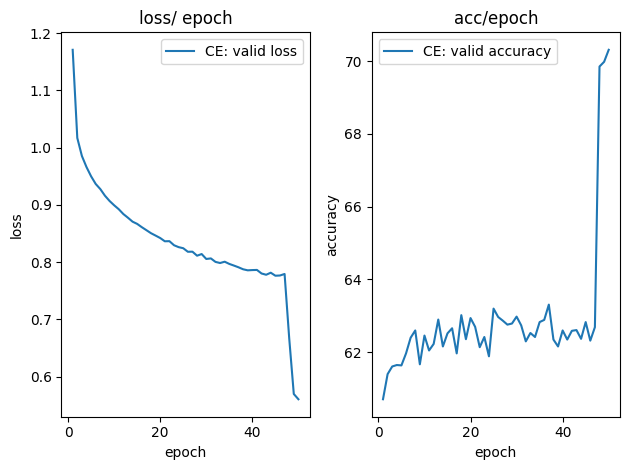

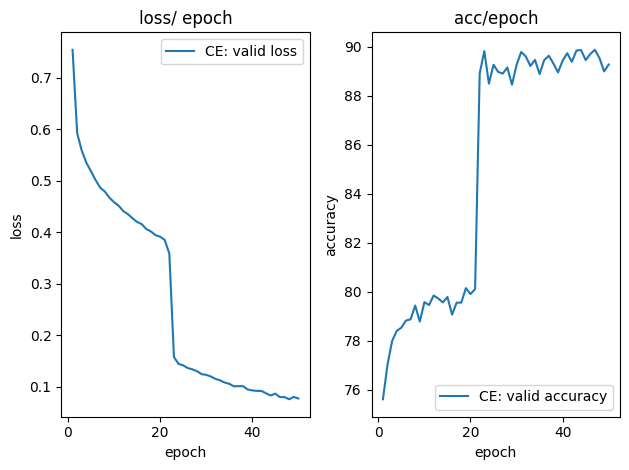

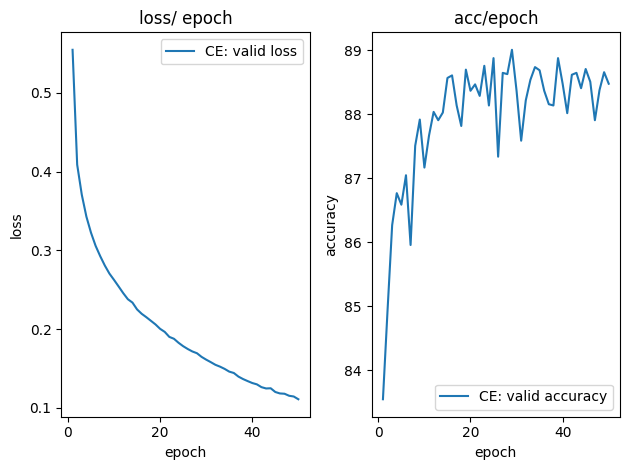

In [ ]:
#CE 시각화
loss_label = 'CE'
metrics(loss_deep_CE, acc_deep_CE, loss_label)
metrics(loss_normal_CE, acc_normal_CE, loss_label)
metrics(loss_shallow_CE, acc_shallow_CE, loss_label)

In [ ]:
%%time
#학습
# MSE
device='cpu' # .to(device) 안지우고 cpu 입력
import time
def train_MSE(model):
  start = time.time()
  #손실함수 및 옵티마이저 정의
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  model = model.to(device)
  train_loss = []
  valid_acc = []
  for epoch in range(num_epochs):

    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device) #gpu사용 시 적용
        labels = labels.to(device)

        # ont hot encode
        one_hot = F.one_hot(labels, num_classes).float() #float 이유: int64->float32

        #순전파
        outputs = F.softmax(model(images), dim=1) # shape: [128, 10]; 10에 대해 계산, 출력층에 softmax 입력
        loss = criterion(outputs, one_hot) # mse 계산

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss/len(train_loader)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)
        one_hot = F.one_hot(labels, num_classes).float()
        outputs = F.softmax(model(images), dim=1)
        _, predicts = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicts == labels).sum().item()

      accuracy = 100 * correct / total

      train_loss.append(avg_loss)
      valid_acc.append(accuracy)


      if (epoch+1)%5:
        print(f'Epoch[{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

    convergence = estimate_conv(train_loss)

  end = time.time()
  runtime = end-start
  print(f"수렴 에포크 추정: {convergence}")

  print(f"최소 Loss: {min(train_loss):.4f}")
  # 최종 평가 : 최종 epoch이 끝난 후의 테스트 데이터 정확도를 출력함.
  print(f'최종 테스트 정확률: {accuracy:.2f}%')
  print(f'실행 시간: {runtime}')

  return train_loss, valid_acc, convergence, runtime




CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10 µs


In [ ]:
%time
loss_deep_MSE, acc_deep_MSE, conv_deep_MSE, time_deep_MSE = train_MSE(deep_MSE)
%time
loss_normal_MSE, acc_normal_MSE, conv_normal_MSE, time_normal_MSE = train_MSE(normal_MSE)
%time
loss_shallow_MSE, acc_shallow_MSE, conv_shallow_MSE, time_shallow_MSE = train_MSE(shallow_MSE)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Epoch[1/50], Loss: 0.0553, Validation Accuracy: 55.04%
Epoch[2/50], Loss: 0.0464, Validation Accuracy: 56.20%
Epoch[3/50], Loss: 0.0452, Validation Accuracy: 56.15%
Epoch[4/50], Loss: 0.0444, Validation Accuracy: 56.44%
Epoch[6/50], Loss: 0.0435, Validation Accuracy: 56.42%
Epoch[7/50], Loss: 0.0433, Validation Accuracy: 57.23%
Epoch[8/50], Loss: 0.0431, Validation Accuracy: 56.88%
Epoch[9/50], Loss: 0.0427, Validation Accuracy: 57.09%
Epoch[11/50], Loss: 0.0424, Validation Accuracy: 57.46%
Epoch[12/50], Loss: 0.0423, Validation Accuracy: 57.49%
Epoch[13/50], Loss: 0.0420, Validation Accuracy: 57.56%
Epoch[14/50], Loss: 0.0420, Validation Accuracy: 56.73%
Epoch[16/50], Loss: 0.0415, Validation Accuracy: 57.41%
Epoch[17/50], Loss: 0.0414, Validation Accuracy: 57.30%
Epoch[18/50], Loss: 0.0413, Validation Accuracy: 57.31%
Epoch[19/50], Loss: 0.0413, Validation Accuracy: 57.41%
Epoch[21/50], Loss: 0.0410, Validation Accuracy:

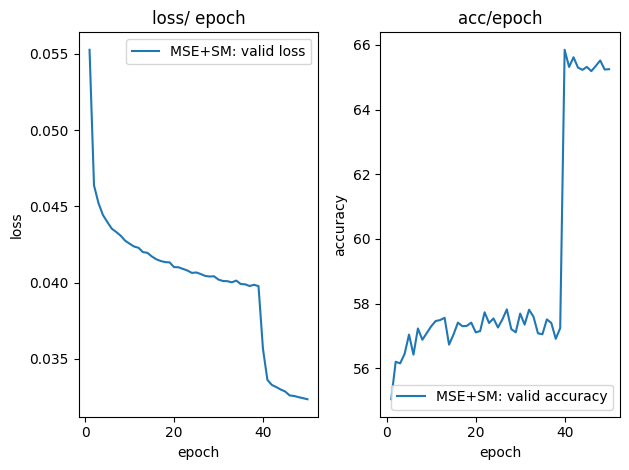

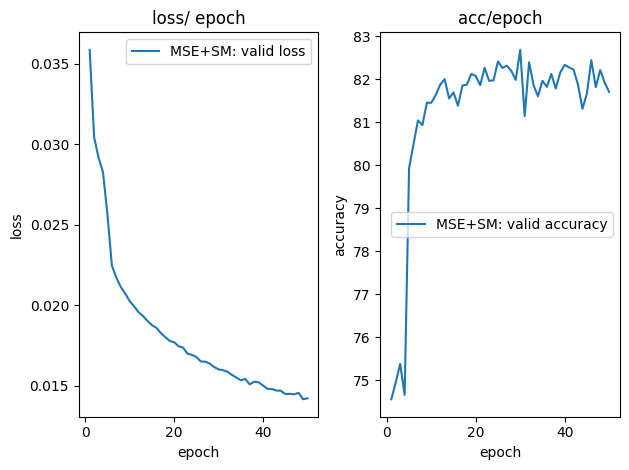

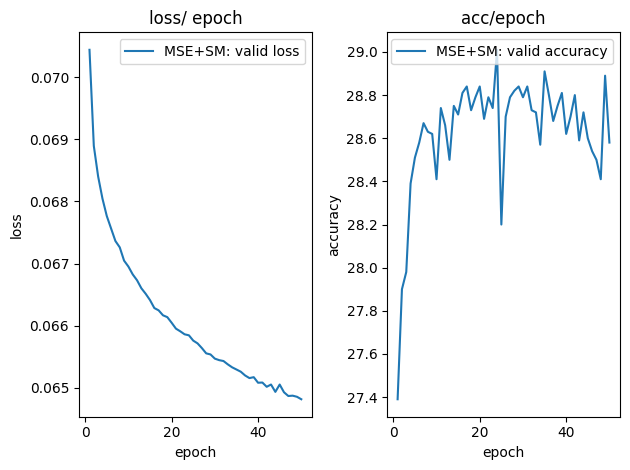

In [ ]:
# MSE+SM 시각화
lf = 'MSE+SM'
metrics(loss_deep_MSE, acc_deep_MSE, lf)
metrics(loss_normal_MSE, acc_normal_MSE, lf)
metrics(loss_shallow_MSE, acc_shallow_MSE, lf)

<ipython-input-15-7e36ab3ebf7e>:74: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7e36ab3ebf7e>:74: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


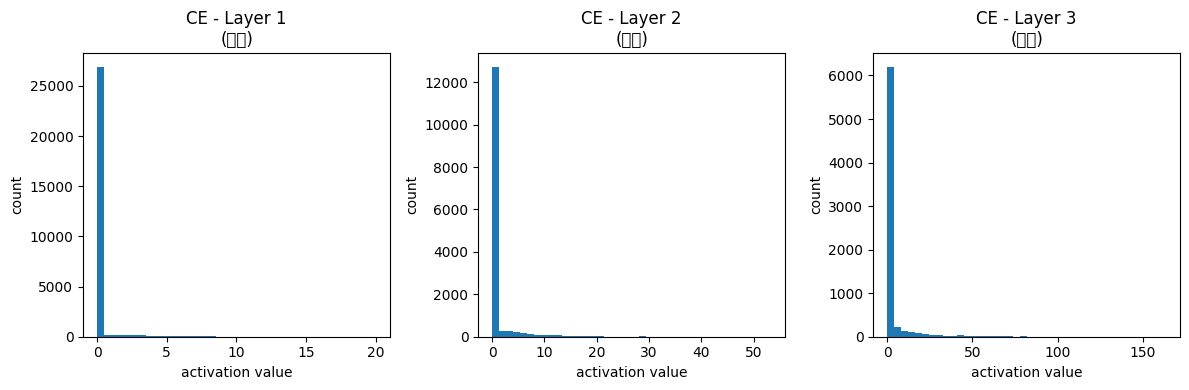

<ipython-input-15-7e36ab3ebf7e>:74: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7e36ab3ebf7e>:74: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


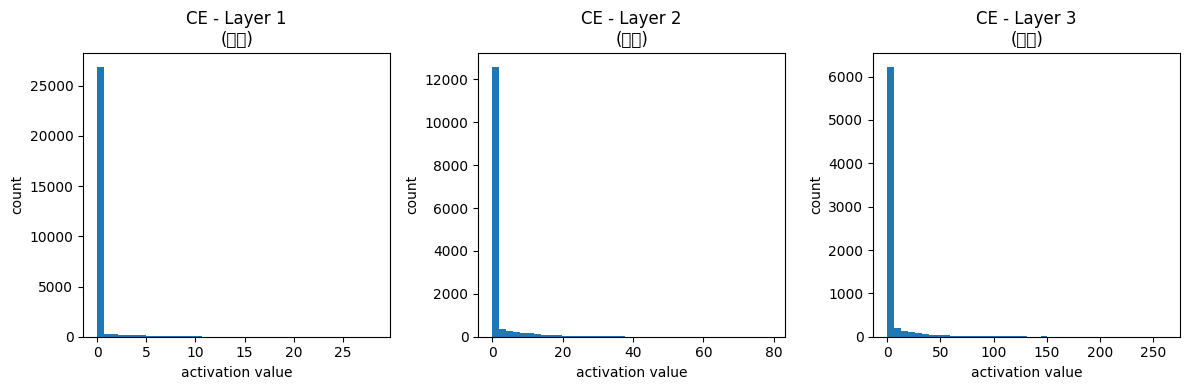

<ipython-input-15-7e36ab3ebf7e>:74: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7e36ab3ebf7e>:74: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


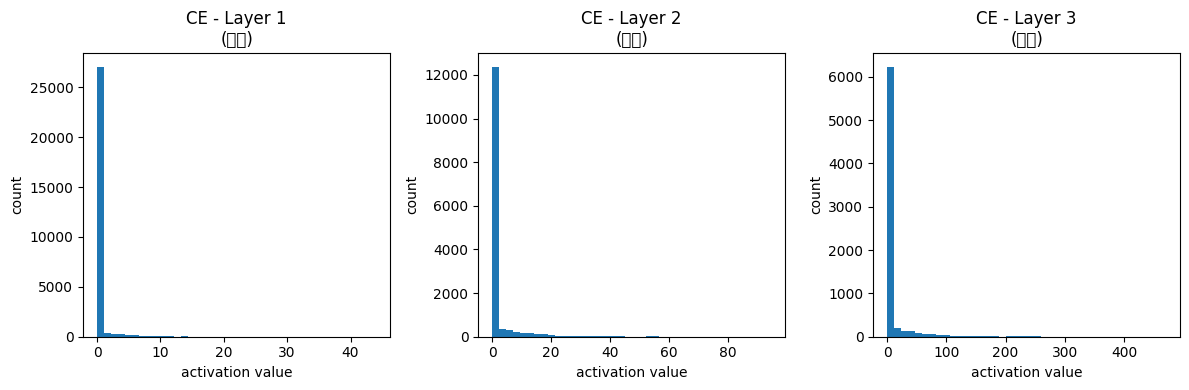

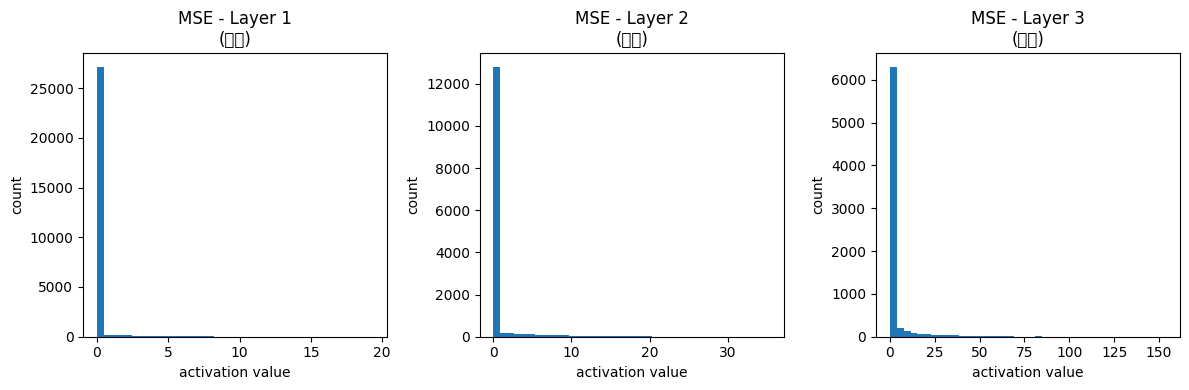

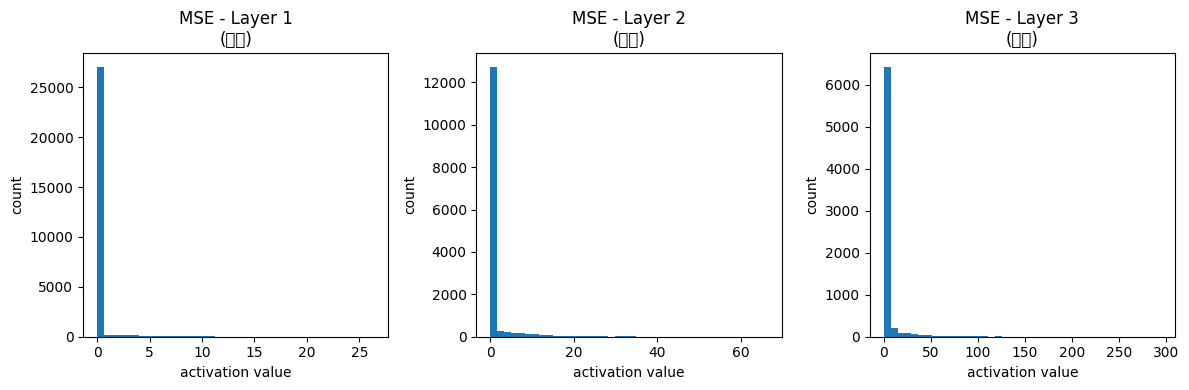

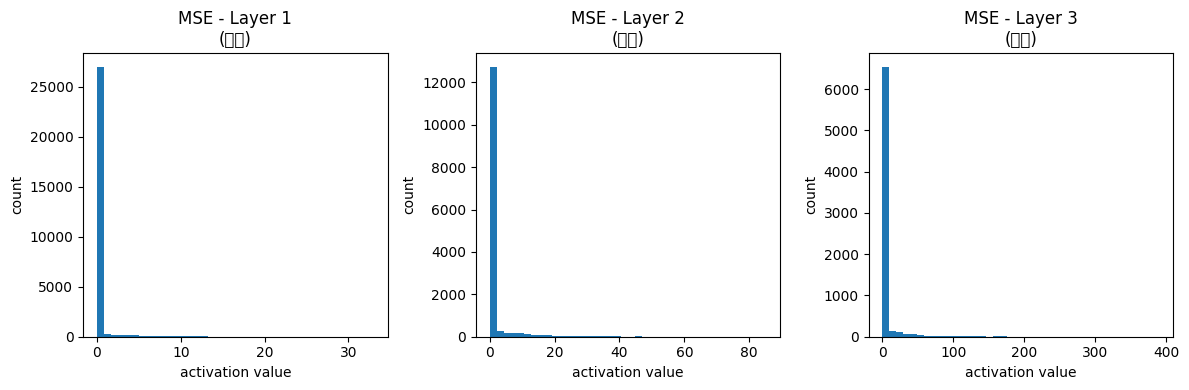

In [ ]:
import matplotlib.pyplot as plt

def visualize_activation_distribution(model, dataset, label, epoch_tag=""):
    """
    특정 모델에서 각 은닉층의 활성화 출력 분포를 시각화합니다.
    - model: 학습된 PyTorch 모델
    - dataset: 시각화를 위한 입력 데이터 (예: test_loader)
    - label: 모델 이름 (예: 'CrossEntropy', 'MSE')
    - epoch_tag: '초기', '중간', '후반' 등 표시용 문자열
    """

    start = time.time()
    #손실함수 및 옵티마이저 정의
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    train_loss = []
    valid_acc = []
    for epoch in range(num_epochs):

      model.train()
      total_loss = 0

      for images, labels in train_loader:
          images = images.reshape(-1, 28*28).to(device) #gpu사용 시 적용
          labels = labels.to(device)

          # ont hot encode
          one_hot = F.one_hot(labels, num_classes).float() #float 이유: int64->float32

          #순전파
          outputs = F.softmax(model(images), dim=1) # shape: [128, 10]; 10에 대해 계산, 출력층에 softmax 입력
          loss = criterion(outputs, one_hot) # mse 계산

          # 역전파
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

      avg_loss = total_loss/len(train_loader)
      model.eval()
      activations = []  # 각 은닉층 출력값 저장

    with torch.no_grad():
        for images, _ in dataset:
            images = images.reshape(-1, 28*28)
            x = images

            # 순차적으로 은닉층 통과시키며 출력값 저장
            x1 = F.relu(model.fc1(x))
            activations.append(x1.numpy().flatten())

            if hasattr(model, 'fc2'):
                x2 = F.relu(model.fc2(x1))
                activations.append(x2.numpy().flatten())

            if hasattr(model, 'fc3'):
                x3 = F.relu(model.fc3(x2))
                activations.append(x3.numpy().flatten())

            break  # 첫 배치만 사용 (시각화 목적)

    # 시각화
    plt.figure(figsize=(12, 4))
    for i, act in enumerate(activations):
        plt.subplot(1, len(activations), i+1)
        plt.hist(act, bins=40)
        plt.title(f'{label} - Layer {i+1}\n({epoch_tag})')
        plt.xlabel('activation value')
        plt.ylabel('count')

    plt.tight_layout()
    plt.show()


# test_loader에서 한 배치 기준 시각화
visualize_activation_distribution(deep_CE, test_loader, label="CE", epoch_tag="초기")
visualize_activation_distribution(deep_CE, test_loader, label="CE", epoch_tag="중간")
visualize_activation_distribution(deep_CE, test_loader, label="CE", epoch_tag="후반")

visualize_activation_distribution(deep_MSE, test_loader, label="MSE", epoch_tag="초기")
visualize_activation_distribution(deep_MSE, test_loader, label="MSE", epoch_tag="중간")
visualize_activation_distribution(deep_MSE, test_loader, label="MSE", epoch_tag="후반")


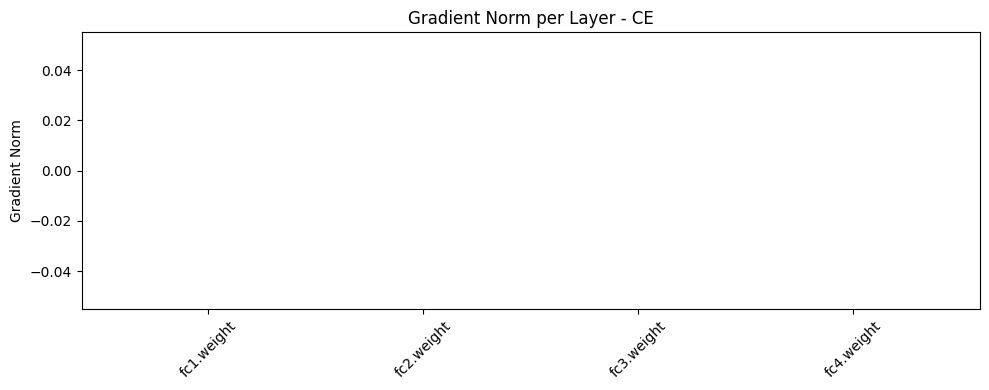

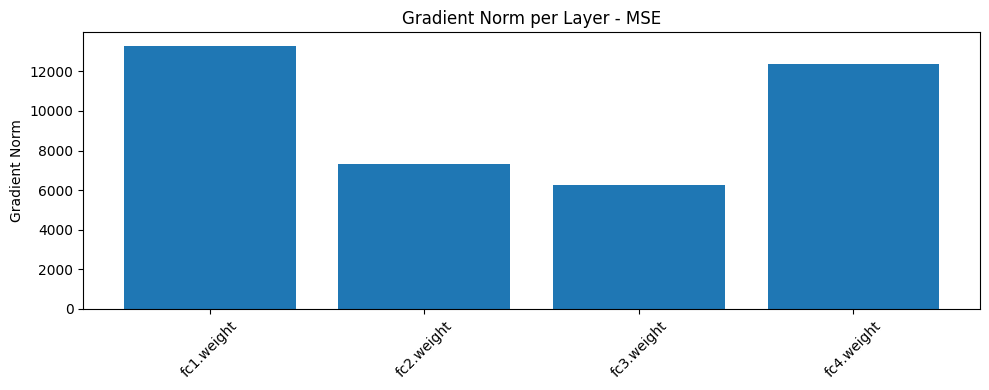

In [ ]:
def visualize_gradient_flow(model, label):
    """
    학습 후 gradient flow를 확인하는 히트맵 또는 바 차트 시각화
    - model: 학습된 모델 (deep_MLP 등)
    - label: 'CE', 'MSE' 등
    """
    model.eval()
    dummy_input = torch.randn(1, 28*28)
    dummy_target = torch.tensor([1])

    criterion = nn.CrossEntropyLoss() if label == 'CE' else nn.MSELoss()
    if label == 'MSE':
        dummy_target = torch.nn.functional.one_hot(dummy_target, num_classes=10).float()

    model.zero_grad()
    output = model(dummy_input)
    loss = criterion(output, dummy_target)
    loss.backward()

    grad_norms = []
    layer_names = []

    for name, param in model.named_parameters():
        if "weight" in name and param.grad is not None:
            grad_norms.append(param.grad.norm().item())
            layer_names.append(name)

    # 시각화
    plt.figure(figsize=(10, 4))
    plt.bar(layer_names, grad_norms)
    plt.xticks(rotation=45)
    plt.title(f"Gradient Norm per Layer - {label}")
    plt.ylabel("Gradient Norm")
    plt.tight_layout()
    plt.show()

visualize_gradient_flow(deep_CE, label='CE')   # CrossEntropy로 학습한 모델
visualize_gradient_flow(deep_MSE, label='MSE') # MSE로 학습한 모델


In [ ]:
import pandas as pd

# 안정성 계산
#compute_stability(loss_list, grad_logs, window=10):


summary = pd.DataFrame({
    '모델': ['deep_MLP', 'MLP', 'shallow_MLP']*2,
    'Loss Function': ['CrossEntropy']*3 + ['MSE+Softmax']*3,
    '최종 정확도 (%)': [
        acc_deep_CE[-1], acc_normal_CE[-1], acc_shallow_CE[-1],
        acc_deep_MSE[-1], acc_normal_MSE[-1], acc_shallow_MSE[-1]
    ],
    'Loss 최솟값': [
        min(loss_deep_CE), min(loss_normal_CE), min(loss_shallow_CE),
        min(loss_deep_MSE), min(loss_normal_MSE), min(loss_shallow_MSE)
    ],
    '수렴 Epoch': [
        conv_deep_CE, conv_normal_CE, conv_shallow_CE,
        conv_deep_MSE, conv_normal_MSE, conv_shallow_MSE
    ],
    '실행 시간(초)': [
        f"{time_deep_CE:.2f}", f"{time_normal_CE:.2f}", f"{time_shallow_CE:.2f}",
        f"{time_deep_MSE:.2f}", f"{time_normal_MSE:.2f}", f"{time_shallow_MSE:.2f}"
    ]
})
# print(summary)
summary

,모델,Loss Function,최종 정확도 (%),Loss 최솟값,수렴 Epoch,실행 시간(초)
0,deep_MLP,CrossEntropy,70.49,0.546798,50,742.47
1,MLP,CrossEntropy,88.45,0.071130,50,587.17
2,shallow_MLP,CrossEntropy,88.83,0.109766,50,509.61
3,deep_MLP,MSE+Softmax,89.22,0.006278,8,788.09
4,MLP,MSE+Softmax,81.85,0.014398,7,616.24
5,shallow_MLP,MSE+Softmax,28.56,0.064839,6,532.66


## 실험 B make_moons, make_circlest(scikit-learn) 2D 비선형 분류 문제, Dead ReLU 및 학습 경계 시각화에 유리

In [ ]:
# [실험 B] 활성화 함수 비교 : ReLU vs LeakyReLU vs Sigmoid

# 1) 실험 목표

# ReLU, LeakyReLU, Sigmoid가 학습에 미치는 영향을 분석
# Dead ReLU 발생 유도 및 LeakyReLU의 완화 효과 확인
# 2) 추천 데이터셋 : make_moons, make_circles

# 3) 실험 조건

# 동일 네트워크 및 손실함수(CrossEntropy), Optimizer(Adam 또는 SGD)
# weight 초기값을 std=0.01 등 작게 설정하여 dead neuron 상황 유도
# 4) 분석 포인트

# Layer별 출력값 시각화 (matplotlib 사용)
# Sigmoid는 vanishing gradient 발생 → 학습 정체 확인
# Dead ReLU 발생 시 어떤 지표가 정체되는지 분석
# Dead ReLU가 발생한 neuron 비율 측정 → 히트맵 시각화
# LeakyReLU가 Dead ReLU 문제를 얼마나 완화하는지 시각적 분석


In [ ]:
#@title make moons
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.nn import leaky_relu

import tensorflow.keras.datasets as datasets

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import time
import os

#시드 고정
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # 파이썬 내부 해시 결정론화
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # GPU 연산 결정론화
set_seed(1)



X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
print(X.shape, y.shape) #(200, 2) (200,)
print(X[:2,:], y[:2])
print(type(X))

# 하이퍼 파라미터 설정
input_size = (2,)

num_epochs = 500 #make_moons 200 ~ 500
batch_size = 32
learning_rate = 0.001

initializer = RandomNormal(stddev=0.001)
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy()

# # 데이터 로더 정의
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# GPU 사용 가능 여부
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device) # cuda 출력되면 GPU 활성화 완료
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('gpu:', tf.test.is_gpu_available()) # cuda 출력되면 GPU 활성화 완료

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


(200, 2) (200,)
[[-1.10689665  0.04229281]
 [ 0.95679964  0.45675049]] [0 0]
<class 'numpy.ndarray'>
gpu: False


In [ ]:
# 데이터셋 분리
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(160, 2) (40, 2) (160,) (40,)


In [ ]:
# 텐서 변환
train_X = tf.convert_to_tensor(train_X, dtype=tf.float32)
train_y = tf.convert_to_tensor(train_y.reshape(-1,1), dtype=tf.float32)
test_X = tf.convert_to_tensor(test_X, dtype=tf.float32) #test_X.reshape(-1,1)
test_y = tf.convert_to_tensor(test_y.reshape(-1,1), dtype=tf.float32)


In [ ]:
# 모델 생성
#relu, leaky, sig
build_model = lambda activation: Sequential([
    Input(shape=(2,)),
    Dense(128, activation=activation, kernel_initializer=initializer),
    Dense(64, activation=activation, kernel_initializer=initializer),
    Dense(32, activation=activation, kernel_initializer=initializer),
    Dense(16, activation=activation, kernel_initializer=initializer),
    Dense(8, activation=activation, kernel_initializer=initializer),
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

In [ ]:
# 시각화

def metrics(loss, acc, label):
  plt.subplot(1,2,1)
  plt.plot(range(1, len(loss)+1), loss, label=f'{label}: train loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('loss/ epoch')
  plt.legend(loc='best')

  plt.subplot(1,2,2)
  plt.plot(range(1, len(acc)+1), acc, label=f'{label}: validation accuracy')
  plt.xlabel("epoch")
  plt.ylabel('accuracy')
  plt.title('acc/epoch')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.show()

#손실변화량 - 손실값으로만 계산
def estimate_conv(loss, patience=5, threshold=0.001):
  for i in range(len(loss) - patience): #patience->5
    #최근 patience 에폭 동안 변화량 계산
    window = loss[i:i + patience]
    recent_change = [abs(window[j+1] - window[j]) for j in range(len(window)-1)]
    if all(diff < threshold for diff in recent_change):
      return i+patience # 수렴 시점 이후
  return len(loss) #수렴 안됐으면 전체 로스 수 반환

In [ ]:
# 모델 학습 함수
def make_train_step(model, optimizer): # 클로저로 함수를 한번만 생성
    # 그래프로 만들어서 계산 빠르게 함
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape: #자동미분(훈련)
            logit = model(x, training=True)
            loss = loss_fn(y, logit)
        gradients = tape.gradient(loss, model.trainable_variables) #자동미분
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return logit, loss, gradients
    return train_step

def train(activation_fn,activation_label):
  start = time.time() # 시작

  model = build_model(activation_fn)

  train_loss = []
  train_acc = []

  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(batch_size).batch(batch_size)

  grad_logs = []

  optimizer = Adam(learning_rate=learning_rate)
  train_step = make_train_step(model, optimizer)

  convergence = 0

  for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    # 훈련집합만 사용, 학습만 확인
    for x, y in dataset:
      logit, loss, grads = train_step(x, y)

      epoch_loss += loss
      predict = tf.cast(logit>0.5, tf.float32)
      correct += tf.reduce_sum(tf.cast(predict==y, tf.float32)).numpy()
      total += x.shape[0]

    train_loss.append(epoch_loss/total)
    train_acc.append(correct/total)

    epoch_grads = []
    for var, grad in zip(model.trainable_variables, grads):
        if grad is not None:
            epoch_grads.append(tf.reduce_mean(tf.abs(grad)).numpy())
    grad_logs.append(epoch_grads)

    # 손실변화량
    convergence = estimate_conv(train_loss)
  end = time.time()
  runtime = end-start

  print(f'수렴 에포크 추정: {convergence}')
  print(f"최소 훈련 Loss: {min(train_loss):.4f}")
  # 최종 평가 : 최종 epoch이 끝난 후의 테스트 데이터 정확도를 출력함.
  print(f'최종 훈련 정확률: {correct/total:.2f}%')
  print(f'실행 시간: {runtime:.2f}')
  return model, train_loss, train_acc, grad_logs, convergence, runtime

In [ ]:
# 활성화함수마다 측정, 학습
act_fn = [relu, leaky_relu, sigmoid]
act_name = ['ReLU', 'LeakyReLU', 'sigmoid']
result = {}
# grad_logs = {
#     'ReLU': [],
#     'LeakyReLU': [],
#     'sigmoid': []
# }
grad_logs={}
for name, func in zip(act_name, act_fn):
  %time
  model, loss, acc, logs, conv, runtime = train(func, name)
  result[name] = {'model':model, 'loss':loss, 'accuracy':acc,
                  'final_accuracy': acc[-1], 'min_loss': float(np.min(loss)),
                  'convergence':conv, 'runtime':f'{runtime:.2f}'}
  grad_logs[name] = logs

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
수렴 에포크 추정: 5
최소 훈련 Loss: 0.0217
최종 훈련 정확률: 0.51%
실행 시간: 6.85
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
수렴 에포크 추정: 5
최소 훈련 Loss: 0.0030
최종 훈련 정확률: 0.94%
실행 시간: 7.47
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.39 µs
수렴 에포크 추정: 5
최소 훈련 Loss: 0.0217
최종 훈련 정확률: 0.51%
실행 시간: 7.34


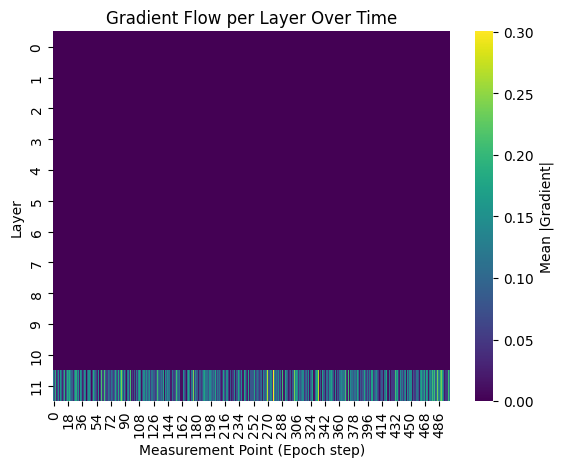

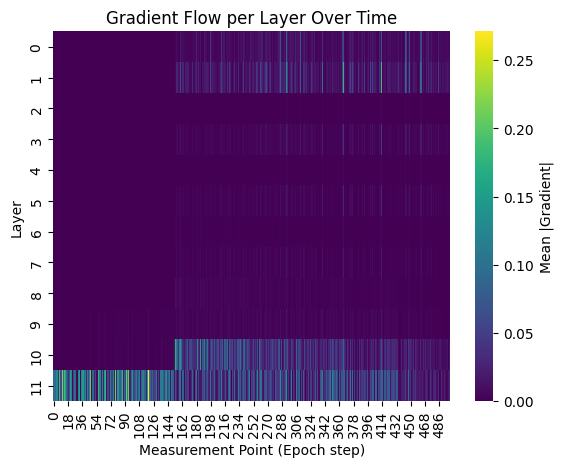

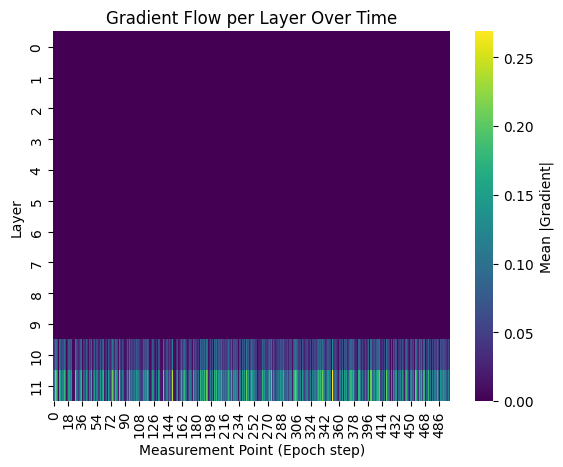

In [ ]:
#그래디언트 소실 시각화
import matplotlib.pyplot as plt

for name in act_name:
  df = pd.DataFrame(grad_logs[name]).T  # shape: (layer, epoch steps)
  sns.heatmap(df, cmap="viridis", annot=False, cbar_kws={'label': 'Mean |Gradient|'})
  plt.title("Gradient Flow per Layer Over Time")
  plt.xlabel("Measurement Point (Epoch step)")
  plt.ylabel("Layer")
  plt.show()

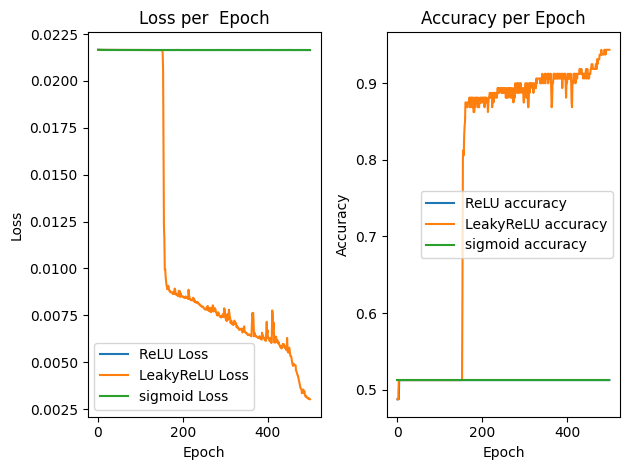

In [ ]:
# 학습 곡선 시각화
plt.figure()

#loss
plt.subplot(1, 2, 1)
for name in result:
  plt.plot(range(1,num_epochs+1), result[name]['loss'], label=f"{name} Loss")
  plt.title("Loss per  Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')

#acc
plt.subplot(1, 2, 2)
for name in result:
  plt.plot(range(1,num_epochs+1), result[name]['accuracy'], label=f'{name} accuracy')
  plt.title('Accuracy per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')

plt.tight_layout()
plt.show()

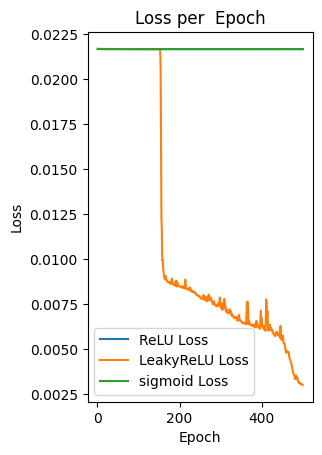

In [ ]:
plt.subplot(1, 2, 1)
for name in ['ReLU', 'LeakyReLU', 'sigmoid']:#
  plt.plot(range(1,num_epochs+1), result[name]['loss'], label=f"{name} Loss")
  # plt.plot(range(1,num_epochs+1), result[name]['loss'], label=f"{name} Loss")
  # plt.plot(range(1,num_epochs+1), result[name]['loss'], label=f"{name} Loss")
  plt.title("Loss per  Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')


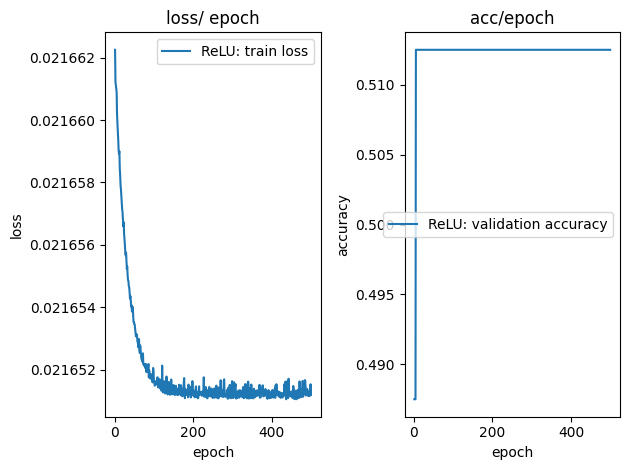

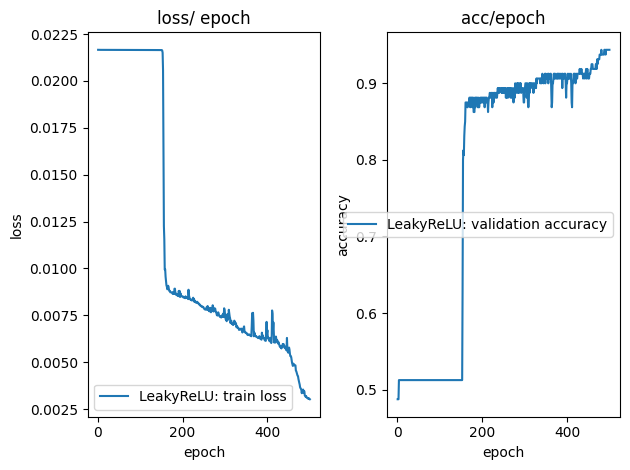

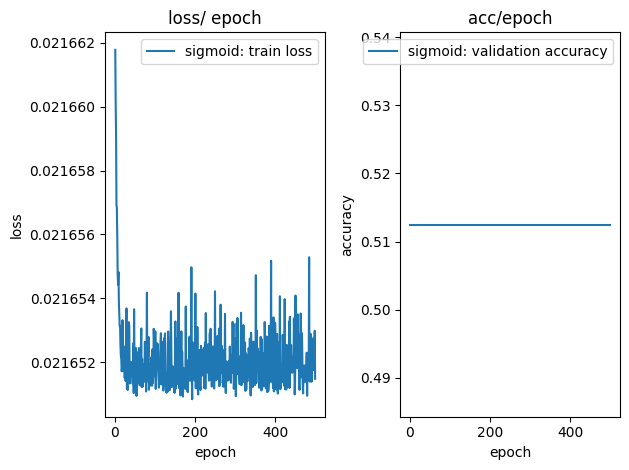

In [ ]:
#시각화(따로)
for name in act_name:
  metrics(result[name]['loss'], result[name]['accuracy'], name)
  # metrics() #loss, acc, label

In [ ]:
print(result['ReLU']['model'])

<Sequential name=sequential, built=True>


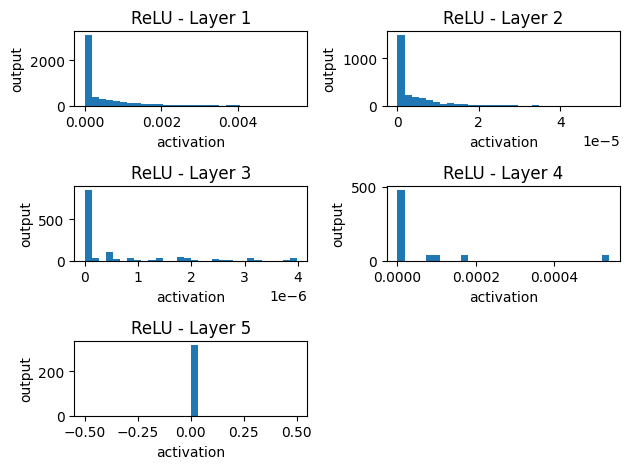

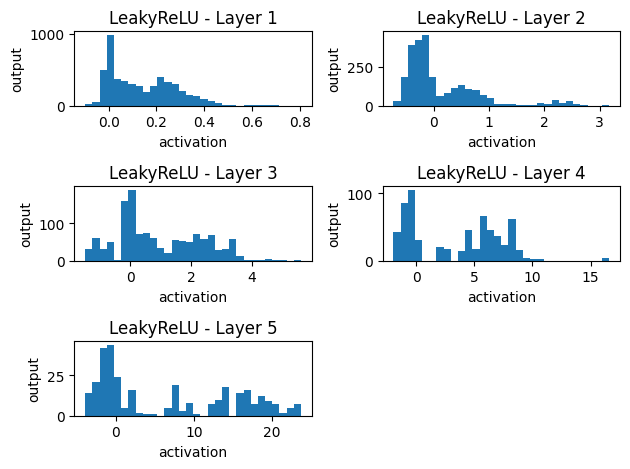

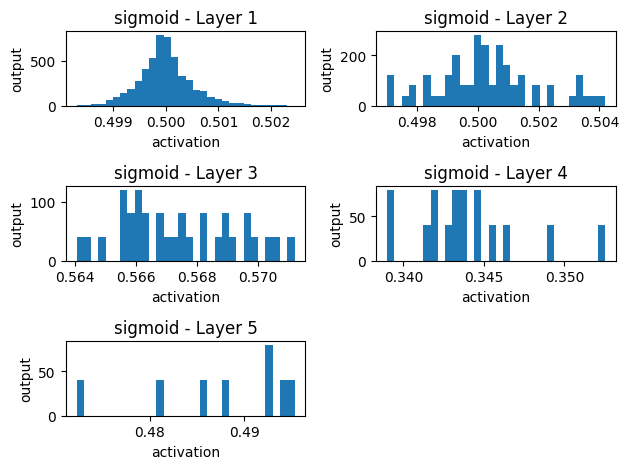

In [ ]:
# 중간 은닉층 출력값 시각화
for name in act_name:
  plt.figure()
  x = test_X #입력 고정
  model = result[name]['model']
    # model = result[name]
    # print(item) -> model; str
    # print(name, item) -> ReLU model
    # print()
  for i, layer in enumerate(model.layers[:-1]): #출력층 제외
      x = layer(x, training=False) #model.layers[i](test_X, training=False)
      plt.subplot(3, 2, i+1)
      plt.hist(x.numpy().flatten(), bins=30)
      plt.title(f'{name} - Layer {i+1}')
      plt.xlabel('activation')
      plt.ylabel('output')
  plt.tight_layout()
  plt.show()

result.keys() = dict_keys(['ReLU', 'LeakyReLU', 'sigmoid'])


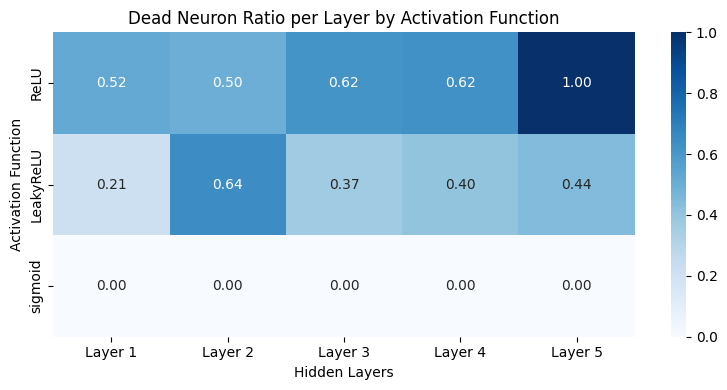

In [ ]:
import numpy as np

# ⚙️ 1. Dead neuron 비율 계산 함수 (Sequential 누적 적용 방식)
def compute_dead_neuron_ratio(name, model, x_input):
    dead_ratios = []
    x = x_input  # 초기 입력
    for i, layer in enumerate(model.layers[:-1]):  # 출력층 제외
        x = layer(x, training=False)  # ✅ 누적 적용
        data = x.numpy() if tf.is_tensor(x) else x

        if name == 'ReLU':
            ratio = np.mean(data <= 0)
        elif name == 'LeakyReLU':
            ratio = np.mean(data < 0)
        elif name == 'sigmoid':
            ratio = np.mean((data < 0.01) | (data > 0.99))
        else:
            raise ValueError(f"Unsupported activation: {name}")

        dead_ratios.append(ratio)
    return dead_ratios

print("result.keys() =", result.keys())
# ✅ 2. Dead ratio 계산
dead_ratio_map = {
    name: compute_dead_neuron_ratio(name, result[name]['model'], test_X) for name,_ in zip(act_name,result)
}

# ✅ 3. 시각화
plt.figure(figsize=(8, 4))
sns.heatmap(
    np.array([dead_ratio_map[name] for name in act_name]),
    annot=True, fmt=".2f", cmap="Blues", cbar=True,
    xticklabels=[f'Layer {i+1}' for i in range(len(next(iter(dead_ratio_map.values()))))],
    yticklabels=act_name
)
plt.title('Dead Neuron Ratio per Layer by Activation Function')
plt.xlabel('Hidden Layers')
plt.ylabel('Activation Function')
plt.tight_layout()
plt.show()


<ipython-input-13-264aa1b6313e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=act_name, y=dead_means, palette="Blues_d")


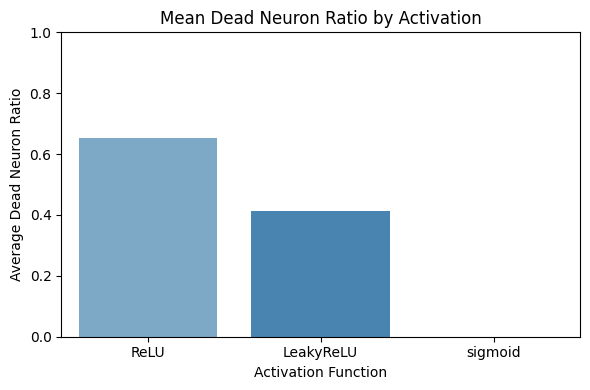

In [ ]:
# ❓의도 설명
# Dead ReLU 비율을 각 activation 함수마다 하나의 평균값으로 요약

# 레이어별 히트맵이 너무 세부적이라면, 이 방식은 전체적인 활성화 성능 비교에 적합함

# 즉, 레이어별 정보는 버리고 각 함수마다 평균적인 죽은 뉴런 비율만 보여주는 요약 시각화입니다.

dead_means = [np.mean(dead_ratio_map[name]) for name in act_name]

plt.figure(figsize=(6,4))
sns.barplot(x=act_name, y=dead_means, palette="Blues_d")
plt.ylabel("Average Dead Neuron Ratio")
plt.xlabel("Activation Function")
plt.title("Mean Dead Neuron Ratio by Activation")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
# 안정성 측정

summary = pd.DataFrame([
    {
        'Activation': name,
        'Final Accuracy (%)': f"{result[name]['final_accuracy']*100:.2f}",
        'Min Loss': f"{result[name]['min_loss']:.4f}",
        'Convergence Epoch': result[name]['convergence'],
        'Mean Gradient (Last Epoch)':np.mean(grad_logs[name][-1]),  # 마지막 epoch의 평균 gradient
        'Dead Neuron Ratio (Mean)': np.mean(dead_ratio_map[name]),  # dead neuron 평균 비율
        'Runtime' : result[name]['runtime']
    }
    for name in act_name if name in result
])
summary


,Activation,Final Accuracy (%),Min Loss,Convergence Epoch,Mean Gradient (Last Epoch),Dead Neuron Ratio (Mean),Runtime
0,ReLU,51.25,0.0217,5,0.009380,0.652148,10.10
1,LeakyReLU,94.38,0.0030,5,0.005676,0.414023,10.32
2,sigmoid,51.25,0.0217,5,0.006170,0.000000,10.40


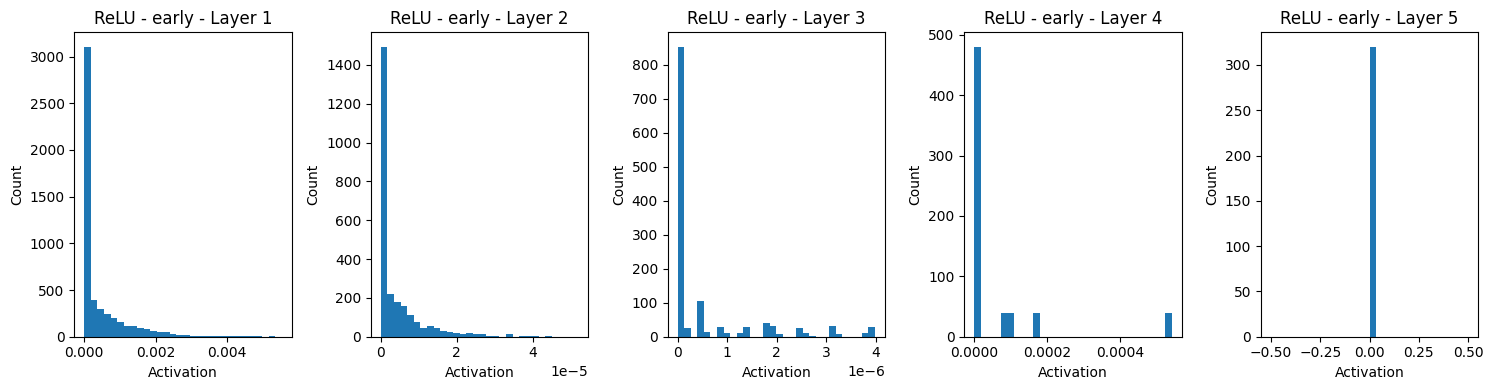

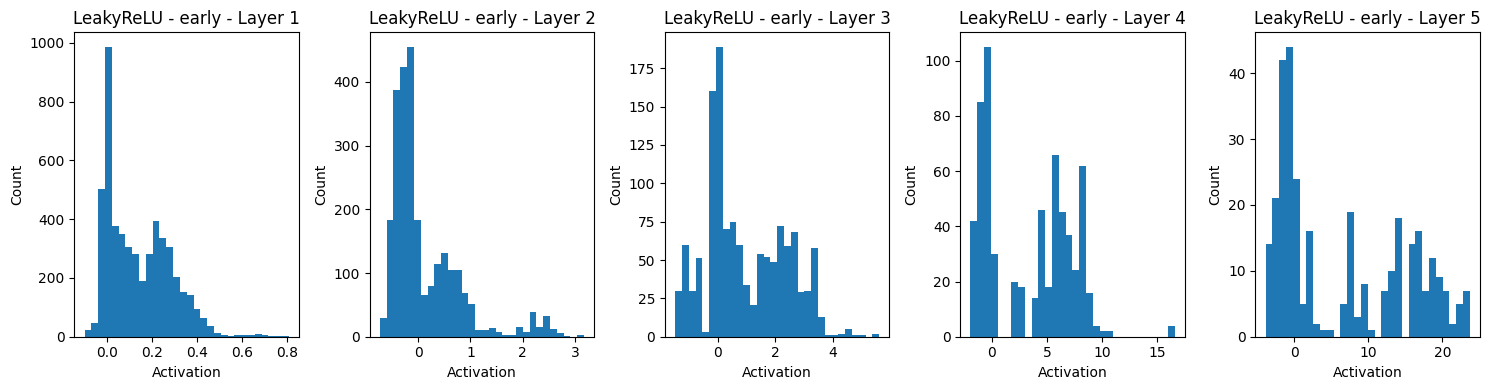

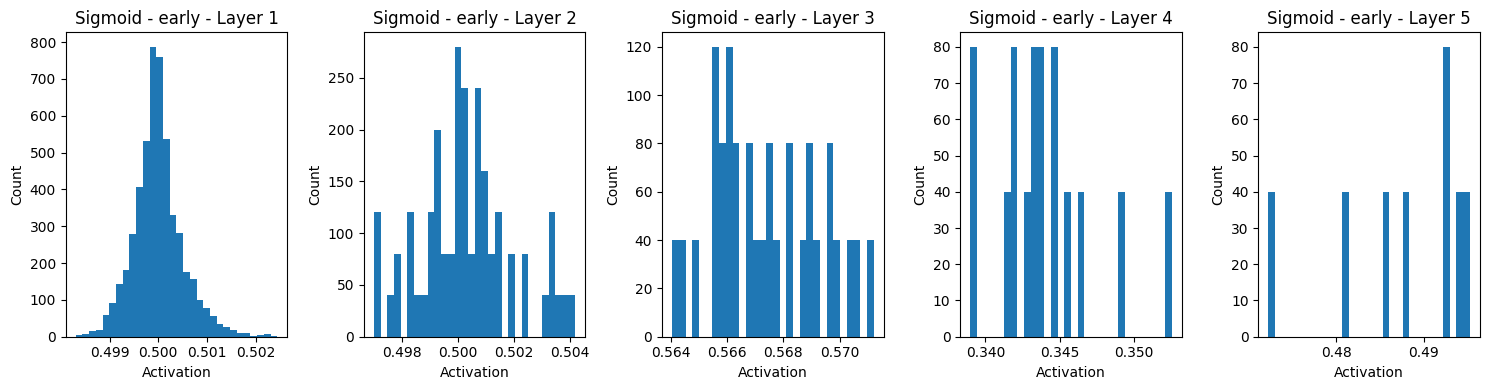

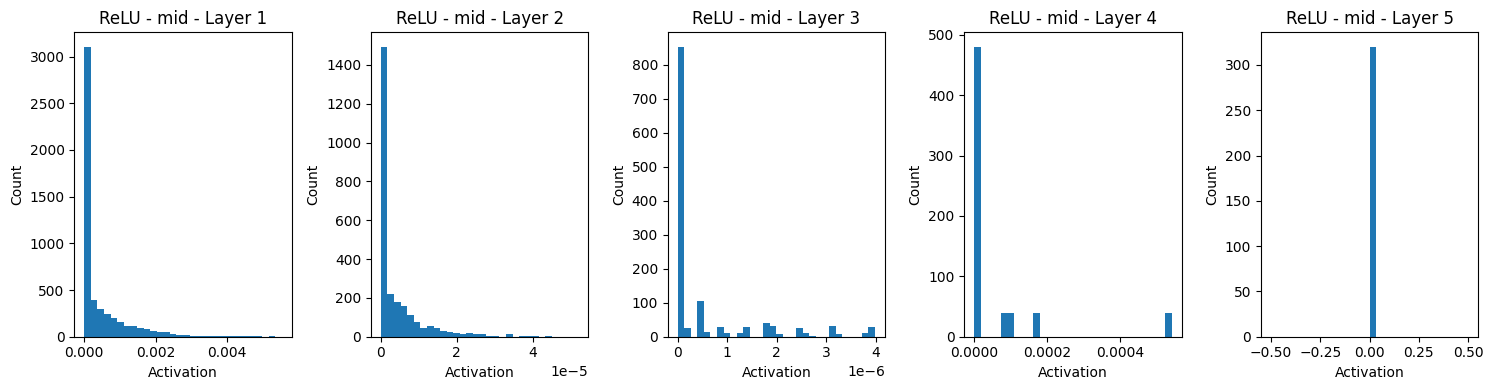

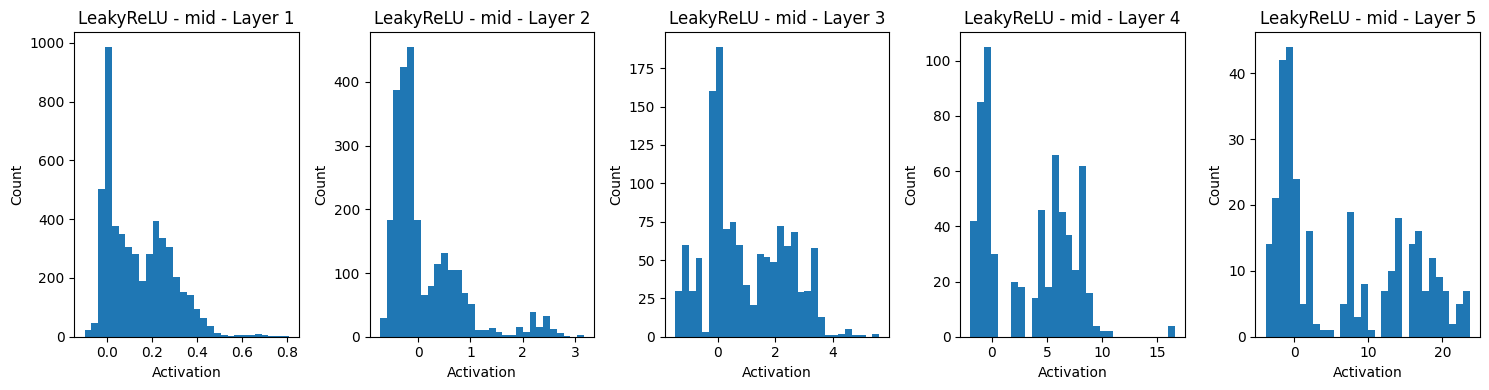

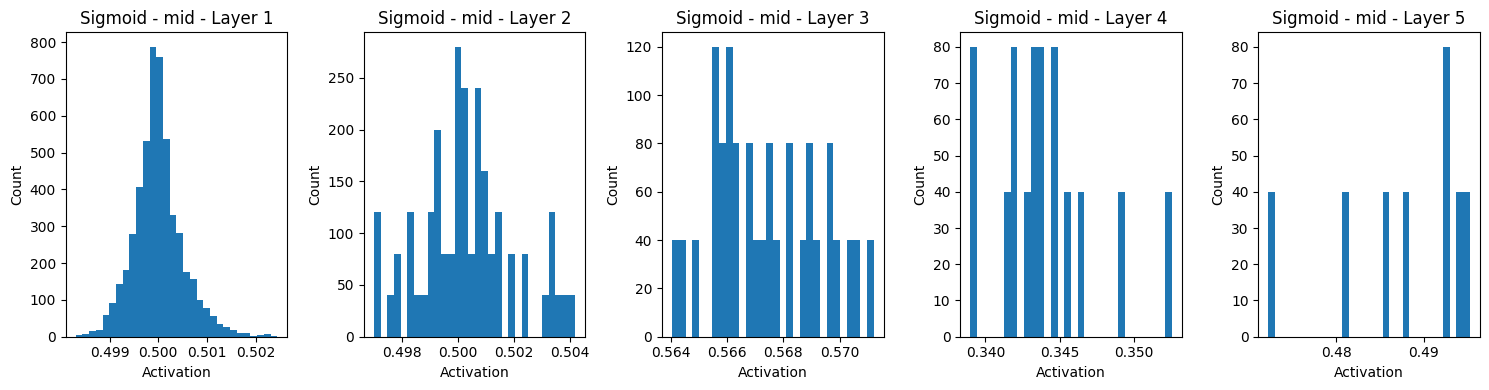

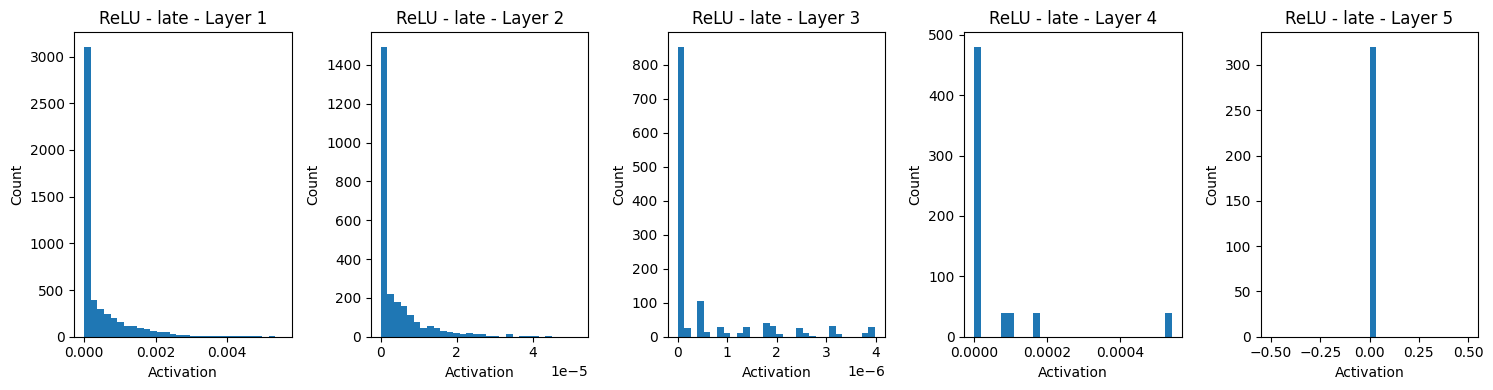

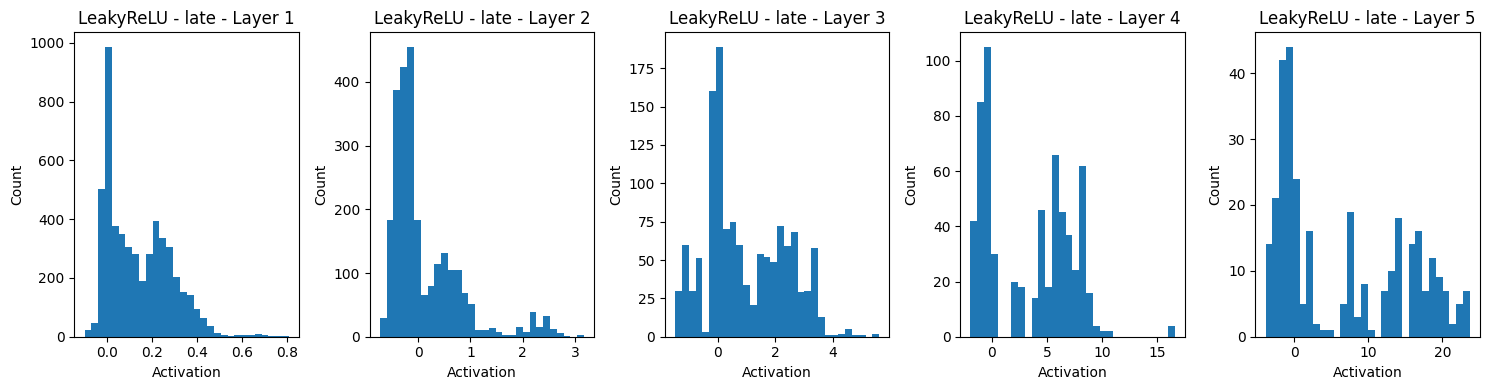

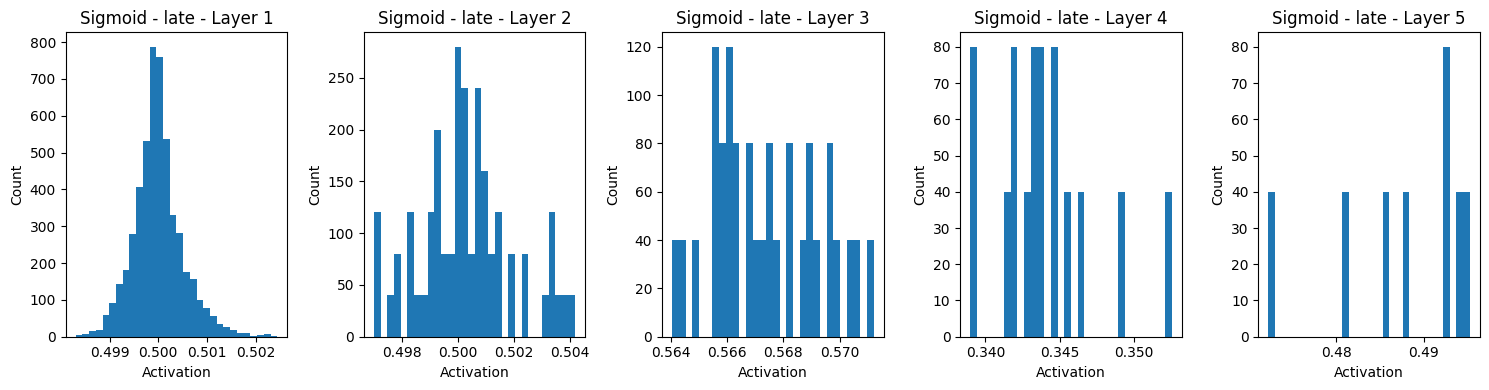

In [ ]:
def visualize_activation_distribution_B(model, data, activation_label, epoch_tag="late"):
    """
    실험 B: 활성화 함수별 layer 출력값 분포 시각화
    - model: 학습된 tf.keras.Sequential 모델
    - data: 입력 데이터 Tensor (예: test_X)
    - activation_label: 'ReLU', 'LeakyReLU', 'Sigmoid'
    - epoch_tag: 'early', 'middle', 'late'
    """
    x = data
    activations = []

    for i, layer in enumerate(model.layers[:-1]):  # 마지막 출력층 제외
        x = layer(x)
        activations.append(x.numpy().flatten())

    # 시각화
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 4))
    for i, act in enumerate(activations):
        plt.subplot(1, len(activations), i+1)
        plt.hist(act, bins=30)
        plt.title(f"{activation_label} - {epoch_tag} - Layer {i+1}")
        plt.xlabel("Activation")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
# 실험 B: 학습 완료 모델 기준 출력 분포 시각화
visualize_activation_distribution_B(result['ReLU']['model'], test_X, activation_label='ReLU', epoch_tag="early")
visualize_activation_distribution_B(result['LeakyReLU']['model'], test_X, activation_label='LeakyReLU', epoch_tag="early")
visualize_activation_distribution_B(result['sigmoid']['model'], test_X, activation_label='Sigmoid', epoch_tag="early")

visualize_activation_distribution_B(result['ReLU']['model'], test_X, activation_label='ReLU', epoch_tag="mid")
visualize_activation_distribution_B(result['LeakyReLU']['model'], test_X, activation_label='LeakyReLU', epoch_tag="mid")
visualize_activation_distribution_B(result['sigmoid']['model'], test_X, activation_label='Sigmoid', epoch_tag="mid")

visualize_activation_distribution_B(result['ReLU']['model'], test_X, activation_label='ReLU', epoch_tag="late")
visualize_activation_distribution_B(result['LeakyReLU']['model'], test_X, activation_label='LeakyReLU', epoch_tag="late")
visualize_activation_distribution_B(result['sigmoid']['model'], test_X, activation_label='Sigmoid', epoch_tag="late")


In [ ]:
print(list(result[name]['loss']))

[<tf.Tensor: shape=(), dtype=float32, numpy=0.021661775186657906>, <tf.Tensor: shape=(), dtype=float32, numpy=0.021660083904862404>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02165914513170719>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02165692113339901>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0216568261384964>, <tf.Tensor: shape=(), dtype=float32, numpy=0.021655937656760216>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02165474370121956>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02165442705154419>, <tf.Tensor: shape=(), dtype=float32, numpy=0.021654827520251274>, <tf.Tensor: shape=(), dtype=float32, numpy=0.021653899922966957>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0216535534709692>, <tf.Tensor: shape=(), dtype=float32, numpy=0.021653123199939728>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02165314182639122>, <tf.Tensor: shape=(), dtype=float32, numpy=0.021652502939105034>, <tf.Tensor: shape=(), dtype=float32, numpy=0.021652210503816605>, <tf.Tensor: shape=

## 실험 C Fashion-MNIST, Digits Dataset Optimizer 성능 차이

In [ ]:
# [실험 C] 최적화 알고리즘 비교 : SGD, SGD+Momentum, Adam

# 1) 실험 목표

# SGD, SGD+Momentum, Adam의 성능 비교
# 학습률 변화가 미치는 영향 분석 (0.1, 0.01, 0.001)
# 2) 추천 데이터셋: Fashion-MNIST, Digits Dataset

# 3) 실험 조건

# 동일한 네트워크, 손실함수, 데이터셋

# 학습률에 따른 3개의 optimizer 성능 비교 (표로 정리)

# Learning rate를 지수 감소 (Exponential Decay) 적용하여 실험

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# 4) 분석 포인트

# Overshooting, 느린 수렴, 안정성 확인
# 학습률 변화에 따른 Loss 곡선과 Gradient 흐름 분석

In [ ]:
#@title digit
import tensorflow as tf
import tensorflow.keras.datasets as ds
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.nn import leaky_relu

import tensorflow.keras.datasets as datasets

from sklearn.datasets import load_digits

import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import time, os
#시드 고정
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # 파이썬 내부 해시 결정론화
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # GPU 연산 결정론화
set_seed(1)

# 데이터셋 로드: (data, target)
X, y = load_digits(return_X_y=True)

print(X.shape, y.shape) #
# print(X[:2,:], y[:2])
print(type(X))

#정규화
X = X / 16.0

# 분리
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

# 텐서 변환
train_X = tf.convert_to_tensor(train_X, dtype=tf.float32)
train_y = tf.convert_to_tensor(train_y, dtype=tf.int32)
train_y = tf.one_hot(train_y, depth=10) #one hot

test_X = tf.convert_to_tensor(test_X, dtype=tf.float32)
test_y = tf.convert_to_tensor(test_y, dtype=tf.int32)
test_y = tf.one_hot(test_y, depth=10) #one hot


# 하이퍼 파라미터 설정
input_size = train_X[0].shape

num_epochs = 50 #digit 20 ~ 50
batch_size = 32
learning_rate = 0.001

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler_fn = ExponentialDecay #(learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
initializer = 'he_uniform'
# optimizer = Adam(learning_rate=learning_rate) # 추후 생성
loss_fn = CategoricalCrossentropy()

# GPU 사용 가능 여부
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cuda' if

print('gpu:', tf.test.is_gpu_available()) # cuda 출력되면 GPU 활성화 완료
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


(1797, 64) (1797,)
<class 'numpy.ndarray'>
gpu: False


In [ ]:
print(input_size)
print(train_X.shape)
print(train_X[0].shape)
print(train_X[1].shape)
print(train_X[1202].shape)

(64,)
(1203, 64)
(64,)
(64,)
(64,)


In [ ]:
# 모델 생성
def build_model():
  return Sequential([
    Input(shape=(input_size)),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=initializer),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dense(32, activation='relu', kernel_initializer=initializer),
    Dense(16, activation='relu', kernel_initializer=initializer),
    Dense(8, activation='relu', kernel_initializer=initializer),
    Dense(10, activation='softmax', kernel_initializer=initializer),
])

In [ ]:
def evaluate(model, test_X, test_y):
    logits = model(test_X, training=False)
    preds = tf.argmax(logits, axis=1)
    true = tf.argmax(test_y, axis=1)
    loss = loss_fn(test_y, logits).numpy()
    correct = tf.reduce_sum(tf.cast(preds == true, tf.float32)).numpy() # mean 대신 sum으로 하고 train 내부에서 다시 계산

    return loss, correct

# 시각화

def metrics(loss, acc, label):
  plt.subplot(1,2,1)
  plt.plot(range(1, len(loss)+1), loss, label=f'{label}: loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('loss/ epoch')
  plt.legend(loc='best')

  plt.subplot(1,2,2)
  plt.plot(range(1, len(acc)+1), acc, label=f'{label}: accuracy')
  plt.xlabel("epoch")
  plt.ylabel('accuracy')
  plt.title('acc/epoch')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.show()

#손실변화량 - 손실값으로만 계산
def estimate_conv(loss, patience=5, threshold=0.001):
  for i in range(len(loss) - patience): #patience->5
    #최근 patience 에폭 동안 변화량 계산
    window = loss[i:i + patience]
    recent_change = [abs(window[j+1] - window[j]) for j in range(len(window)-1)]
    if all(diff < threshold for diff in recent_change):
      return i+patience # 수렴 시점 이후
  return len(loss) #수렴 안됐으면 전체 로스 수 반환

# 손실 안정성
def compute_stability(loss_list, grad_logs, window=10):
    # window
    if len(loss_list) >= window:
        loss_std = np.std(loss_list[-window:])
    else:
        loss_std = np.std(loss_list)

    # gradient 안정성 (마지막 에폭 기준, 여러 레이어 평균)
    last_grads = grad_logs[-1] if grad_logs else []
    if last_grads:
        grad_mean = float(np.mean(np.abs(last_grads)))
    else:
        grad_mean = 0.0

    return loss_std, grad_mean

In [ ]:
# 훈련
def make_step(model):
  @tf.function()
  def train_step(x, y, optimizer): #SGD
    with tf.GradientTape() as tape:
      logit = model(x, training=True)
      loss = loss_fn(y, logit)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return logit, loss, grads
  return train_step

def train(model, optimizer_class, optimizer_label, grad_logs, use_scheduler):
  start = time.time()
  model = model
  train_loss, train_acc = [], []
  valid_loss, valid_acc = [], []
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(batch_size)
  # grad_logs = {
  #   'SGD': [],
  #   'SGD+Momentum': [],
  #   'ADAM': []
  # }
  name = optimizer_label
  train_step = make_step(model)
  # decay 적용 안했을 때????

  momentum = None
  if name == 'SGD':
        learning_rate = 0.1
        lr_schedule = scheduler_fn(learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
        momentum = 0.0
        # optimizer = optimizer_class(learning_rate=lr_schedule, momentum=0.0)
        # logit, loss, grads = train_step1( x, y, optimizer)
  if name == 'SGD+Momentum':
        learning_rate = 0.01
        momentum = 0.99
        lr_schedule = scheduler_fn(learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
        # optimizer = optimizer_class(learning_rate=lr_schedule, momentum=0.99)
        # logit, loss, grads = train_step1(x, y, optimizer)
  if name == 'ADAM':
        learning_rate = 0.001
        lr_schedule = scheduler_fn(learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
        # optimizer = optimizer_class(learning_rate=lr_schedule)

  if use_scheduler:
    if name in ('SGD', 'SGD+Momentum'):
      optimizer = optimizer_class(learning_rate=lr_schedule, momentum=momentum)
    else:
      optimizer = optimizer_class(learning_rate=lr_schedule)
  else:
    if name not in ('ADAM'):
      optimizer = optimizer_class(learning_rate=learning_rate, momentum=momentum)
    else:
      optimizer = optimizer_class(learning_rate=learning_rate)

  print(f'scheduler:{use_scheduler}, optimizer:{optimizer_label}')
  for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for x, y in dataset:
      #  (0.1, 0.01, 0.001)

        # logit, loss, grads = train_step2(x, y, optimizer)
      logit, loss, grads = train_step(x, y, optimizer)

      # print('x.shape[0]',x.shape[0])->19일때있고 대부분32
      epoch_loss += loss.numpy()*x.shape[0]
      predict = tf.argmax(logit, axis=1)
      true = tf.argmax(y, axis=1)
      correct += tf.reduce_sum(tf.cast(predict==true, tf.float32)).numpy()
      total += x.shape[0]
    train_loss.append(epoch_loss/total)
    train_acc.append(correct/total)

    epoch_grads = []
    for var, grad in zip(model.trainable_variables, grads):
        if grad is not None:
            epoch_grads.append(tf.reduce_mean(tf.abs(grad)).numpy())
    grad_logs.append(epoch_grads)

    if (epoch+1)%5 == 0:
      print(f'{name}: Epoch {epoch+1}, Loss {train_loss[-1]}, Accuracy {train_acc[-1]}')

    test_total = 0
    test_true, test_loss = 0, 0
    for x, y in test_dataset:
      loss, correct = evaluate(model, x, y)
      test_loss += loss * x.shape[0] #loss*batch
      test_true += correct #reduce_mean -> reduce_sum 변경
      test_total += x.shape[0]
    valid_loss.append(test_loss/test_total)
    valid_acc.append(test_true/test_total)
    convergence = estimate_conv(train_loss)
  end = time.time()
  runtime = end-start
  print(f"[{name}] Final Validation Test Loss: {valid_loss[-1]:.4f}, Accuracy: {valid_acc[-1]:.4f}")
  print(f'수렴 에포크 추정: {convergence}')
  print(f"Minimum Validation Loss: {min(valid_loss):.4f}")
  print(f'실행 시간: {runtime:.2f} 초')
  return model, train_loss, train_acc, valid_loss, valid_acc, convergence, runtime

In [ ]:
# 옵티마이저 따라 학습
optimizers = [SGD, SGD, Adam]
opt_name = ['SGD', 'SGD+Momentum', 'ADAM']
result = {}
result_nosched = {}
# 외부에서 정의
  # grad_logs = {
  #   'SGD': [],
  #   'SGD+Momentum': [],
  #   'ADAM': []
  # }
grad_logs_all = {'SGD':[],
                 'SGD+Momentum': [],
                 'ADAM': []}
grad_logs_all_nosched = {'SGD':[],
                 'SGD+Momentum': [],
                 'ADAM': []}

# 옵티마이저 루프
for use_scheduler in [True, False]: # 스케줄러 사용 여부
  for opt, name in zip(optimizers, opt_name):
      model = build_model()
      model.set_weights(model.get_weights())
      grad_logs = []  # 각 옵티마이저마다 리스트 초기화

      %time
      model, loss, acc, valid_loss, valid_acc, convergence, runtime  = train(model, opt, name, grad_logs, use_scheduler)

      if use_scheduler:
        result[name] = {'model': model,
                        'train_loss': loss, 'train_accuracy': acc,
                        'valid_loss':valid_loss ,'valid_accuracy': valid_acc,
                        'convergence':convergence, 'runtime':runtime}
        grad_logs_all[name] = grad_logs  #로그 저장
      else:
        result_nosched[name] = {'model': model,
                        'train_loss': loss, 'train_accuracy': acc,
                        'valid_loss':valid_loss ,'valid_accuracy': valid_acc,
                        'convergence':convergence, 'runtime':f"{runtime:.2f}"}
        grad_logs_all_nosched[name] = grad_logs

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
scheduler:True, optimizer:SGD
SGD: Epoch 5, Loss 0.7120172381401062, Accuracy 0.8412302732467651
SGD: Epoch 10, Loss 0.06608690321445465, Accuracy 0.9758936166763306
SGD: Epoch 15, Loss 0.00859915092587471, Accuracy 0.9983375072479248
SGD: Epoch 20, Loss 0.0014915951760485768, Accuracy 1.0
SGD: Epoch 25, Loss 0.0008816950139589608, Accuracy 1.0
SGD: Epoch 30, Loss 0.0006217107293196023, Accuracy 1.0
SGD: Epoch 35, Loss 0.0004792189283762127, Accuracy 1.0
SGD: Epoch 40, Loss 0.00038845642120577395, Accuracy 1.0
SGD: Epoch 45, Loss 0.0003257077478338033, Accuracy 1.0
SGD: Epoch 50, Loss 0.00027990684611722827, Accuracy 1.0
[SGD] Final Validation Test Loss: 0.1747, Accuracy: 0.9714
수렴 에포크 추정: 21
Minimum Validation Loss: 0.1249
실행 시간: 12.74 초
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
scheduler:True, optimizer:SGD+Momentum
SGD+Momentum: Epoch 5, Loss 1.5474879741668701, Accuracy 0.4688279330730438
SGD+Mome

In [ ]:
temp = result['SGD']['train_loss']
print(temp)
print(np.sum(temp))
print(np.mean(temp))

[np.float32(2.0934901), np.float32(1.4895533), np.float32(0.91713375), np.float32(0.8262833), np.float32(0.7379236), np.float32(0.9305027), np.float32(0.31687465), np.float32(0.19156025), np.float32(0.097426094), np.float32(0.055472758), np.float32(0.04965475), np.float32(0.021285733), np.float32(0.015321181), np.float32(0.008347855), np.float32(0.0051930053), np.float32(0.003788078), np.float32(0.0029885268), np.float32(0.002500369), np.float32(0.0021550448), np.float32(0.0018502407), np.float32(0.001651926), np.float32(0.0014780224), np.float32(0.0013302262), np.float32(0.0012155253), np.float32(0.0011203681), np.float32(0.0010303619), np.float32(0.0009568906), np.float32(0.0008887995), np.float32(0.0008337392), np.float32(0.00077816326), np.float32(0.0007366268), np.float32(0.0006913652), np.float32(0.0006551421), np.float32(0.0006213491), np.float32(0.0005914942), np.float32(0.00056223705), np.float32(0.0005374356), np.float32(0.0005140225), np.float32(0.00049236516), np.float32(0.

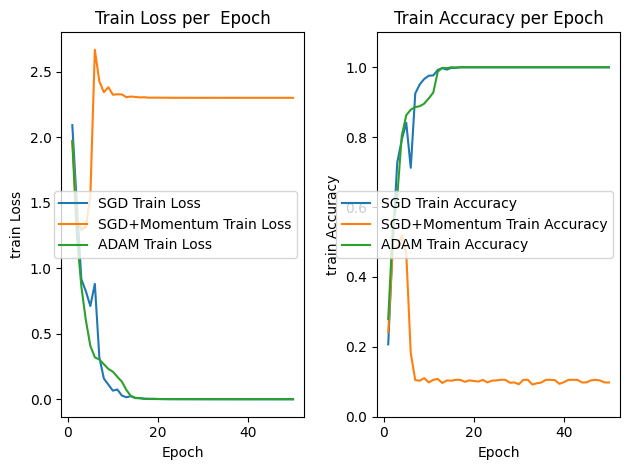

In [ ]:
import matplotlib.pyplot as plt

#TRAIN - scheduled

# loss per epoch
plt.figure()

#loss
plt.subplot(1, 2, 1)
for name in result:
  plt.plot(range(1, num_epochs+1), result[name]['train_loss'], label=f"{name} Train Loss")
  plt.title("Train Loss per  Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("train Loss")
  plt.legend(loc='best')

# accuracy per epoch
plt.subplot(1, 2, 2)
for name in result:
  plt.plot(range(1, num_epochs+1), result[name]['train_accuracy'], label=f'{name} Train Accuracy')
  plt.title('Train Accuracy per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('train Accuracy')
  plt.ylim(0, 1.1)
  plt.legend(loc='best')

plt.tight_layout()
plt.show()

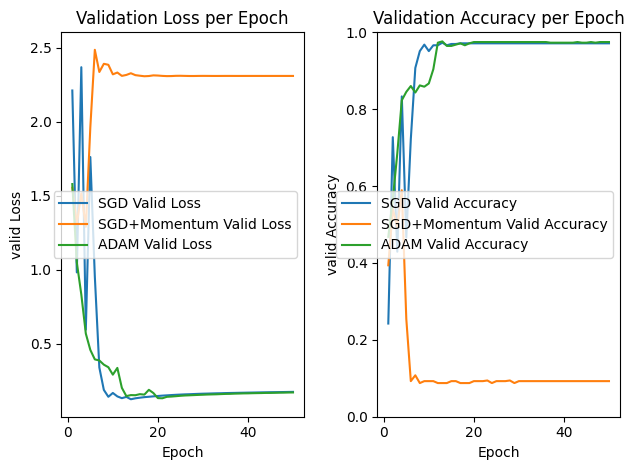

In [ ]:
import matplotlib.pyplot as plt

# VALID - scheduled
# loss per epoch
plt.figure()
# print(list(result[name]['valid_loss']) for name in result)
# print(f'valid_loss.shape: {result[name]['valid_loss']}' for name in result)
#loss
plt.subplot(1, 2, 1)
for name in result:
  plt.plot(range(1, num_epochs+1), result[name]['valid_loss'], label=f"{name} Valid Loss")
  plt.title("Validation Loss per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("valid Loss")
  plt.legend(loc='best')

# accuracy per epoch
plt.subplot(1, 2, 2)
for name in result:
  plt.plot(range(1, num_epochs+1), result[name]['valid_accuracy'], label=f'{name} Valid Accuracy')
  plt.title('Validation Accuracy per Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('valid Accuracy')
  plt.ylim(0, 1)
  plt.legend(loc='best')

plt.tight_layout()
plt.show()

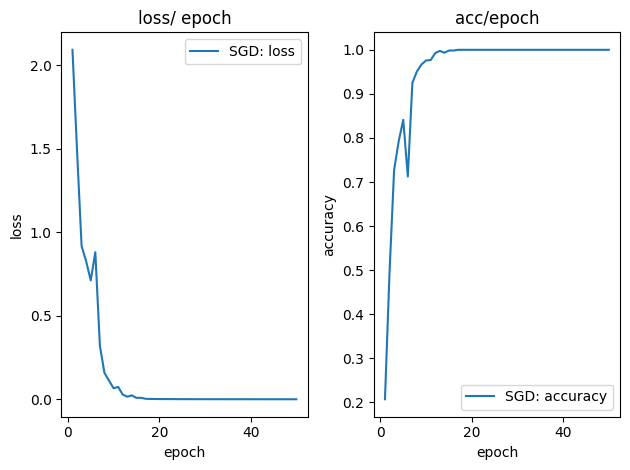

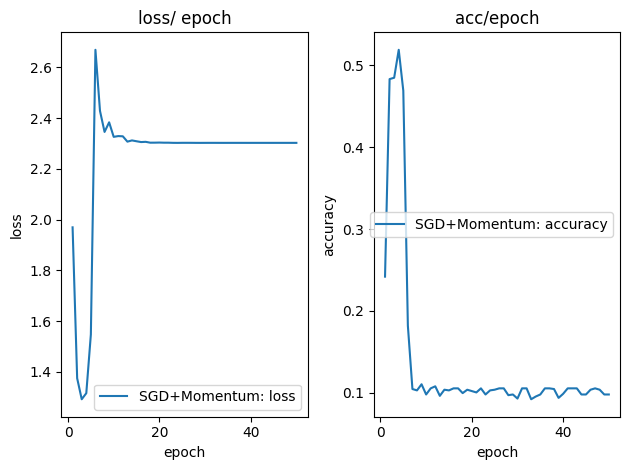

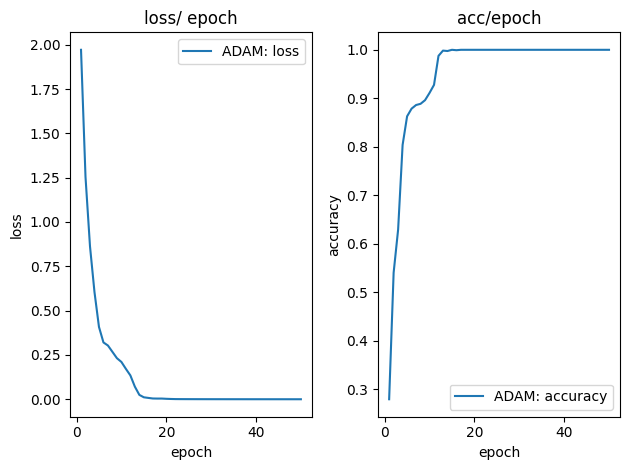

In [ ]:
#따로 train - scheduled
for name in opt_name:
  metrics(result[name]['train_loss'], result[name]['train_accuracy'], name)

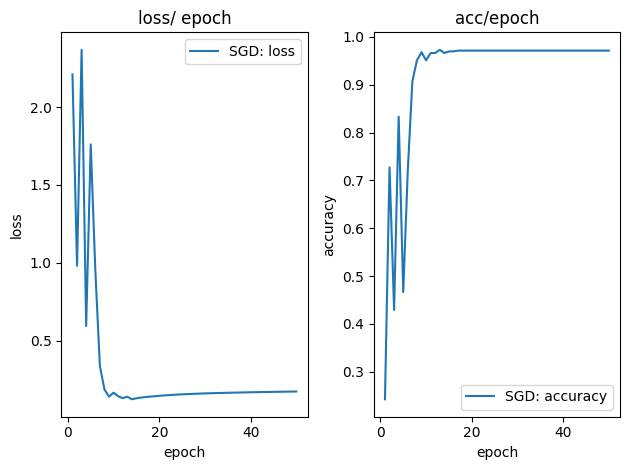

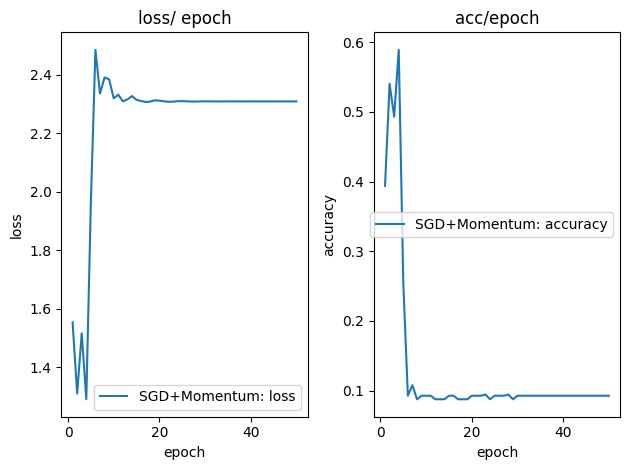

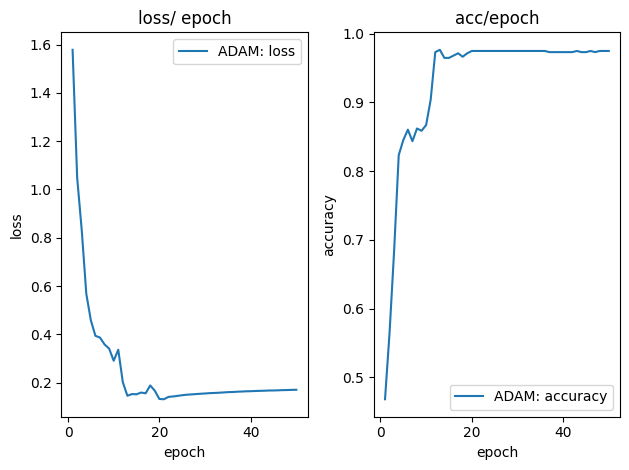

In [ ]:
#따로 test
for name in opt_name:
  metrics(result[name]['valid_loss'], result[name]['valid_accuracy'], name)

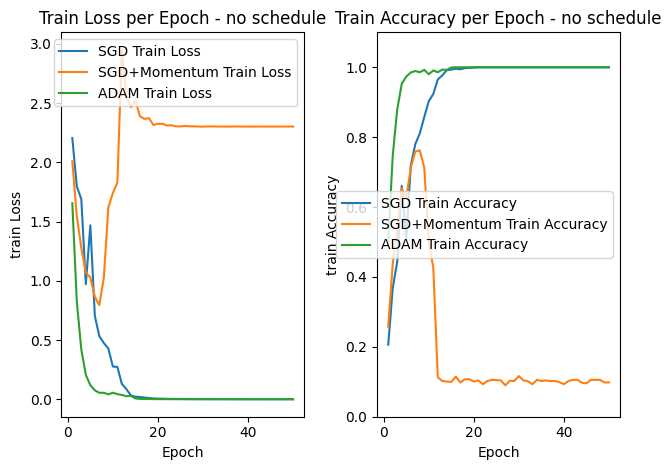

In [ ]:
import matplotlib.pyplot as plt

#TRAIN - no scheduled

# loss per epoch
plt.figure()

#loss
plt.subplot(1, 2, 1)
for name in result_nosched:
  plt.plot(range(1, num_epochs+1), result_nosched[name]['train_loss'], label=f"{name} Train Loss")
  plt.title("Train Loss per Epoch - no schedule")
  plt.xlabel("Epoch")
  plt.ylabel("train Loss")
  plt.legend(loc='best')

# accuracy per epoch
plt.subplot(1, 2, 2)
for name in result_nosched:
  plt.plot(range(1, num_epochs+1), result_nosched[name]['train_accuracy'], label=f'{name} Train Accuracy')
  plt.title('Train Accuracy per Epoch - no schedule')
  plt.xlabel('Epoch')
  plt.ylabel('train Accuracy')
  plt.ylim(0, 1.1)
  plt.legend(loc='best')

plt.tight_layout()
plt.show()

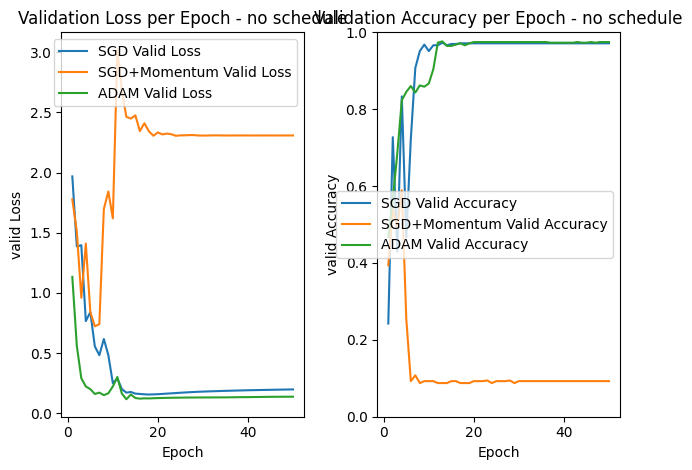

In [ ]:
# VALID - no scheduled
# loss per epoch
plt.figure()
# print(list(result[name]['valid_loss']) for name in result)
# print(f'valid_loss.shape: {result[name]['valid_loss']}' for name in result)
#loss
plt.subplot(1, 2, 1)
for name in result_nosched:
  plt.plot(range(1, num_epochs+1), result_nosched[name]['valid_loss'], label=f"{name} Valid Loss")
  plt.title("Validation Loss per Epoch - no schedule")
  plt.xlabel("Epoch")
  plt.ylabel("valid Loss")
  plt.legend(loc='best')

# accuracy per epoch
plt.subplot(1, 2, 2)
for name in result_nosched:
  plt.plot(range(1, num_epochs+1), result[name]['valid_accuracy'], label=f'{name} Valid Accuracy')
  plt.title('Validation Accuracy per Epoch - no schedule')
  plt.xlabel('Epoch')
  plt.ylabel('valid Accuracy')
  plt.ylim(0, 1)
  plt.legend(loc='best')

plt.tight_layout()
plt.show()

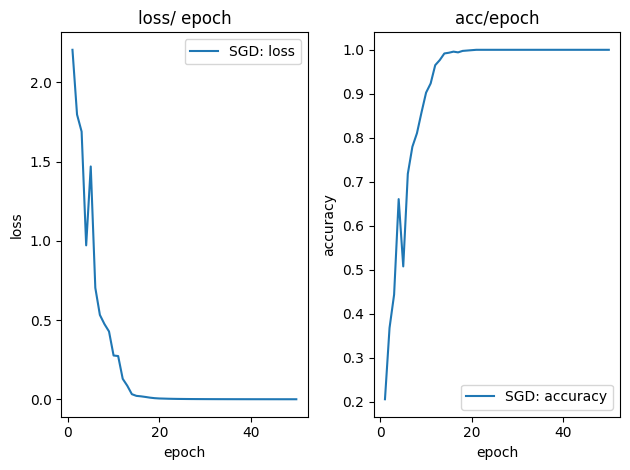

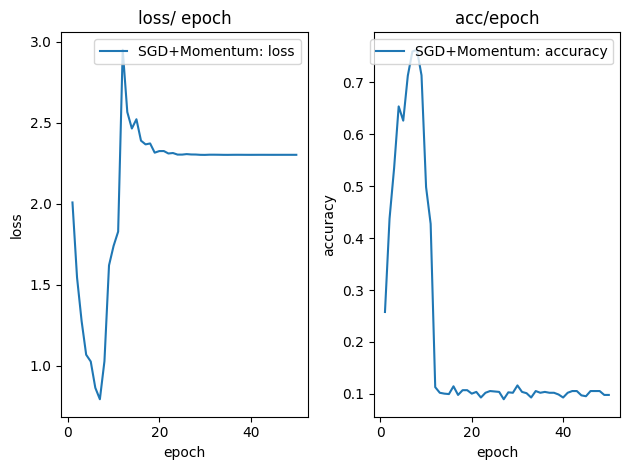

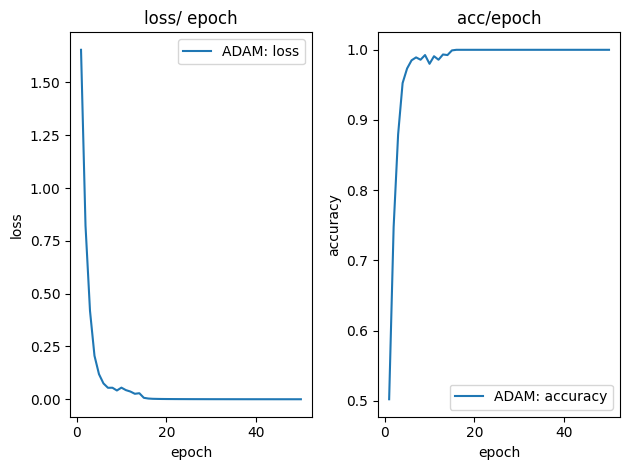

In [ ]:
#따로 train - no scheduled
for name in opt_name:
  metrics(result_nosched[name]['train_loss'], result_nosched[name]['train_accuracy'], name)

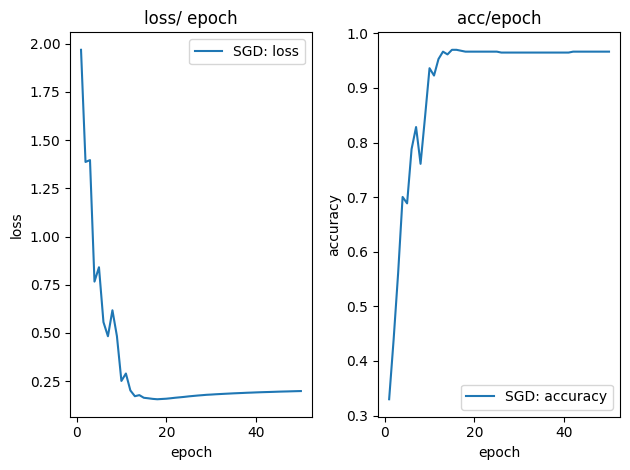

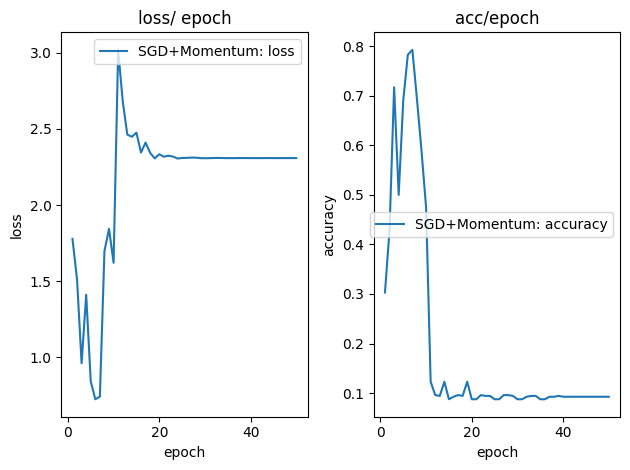

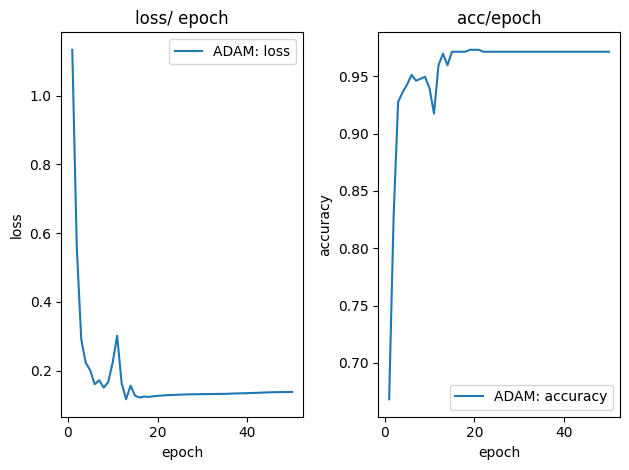

In [ ]:
#따로 train - no scheduled
for name in opt_name:
  metrics(result_nosched[name]['valid_loss'], result_nosched[name]['valid_accuracy'], name)

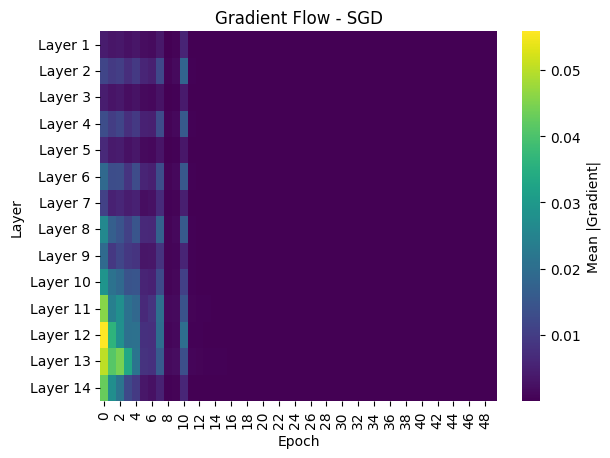

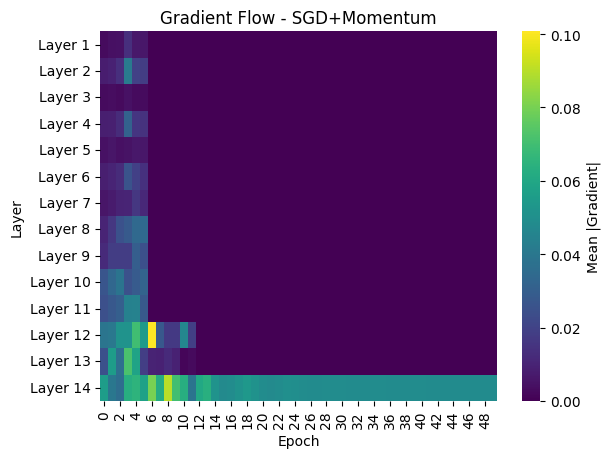

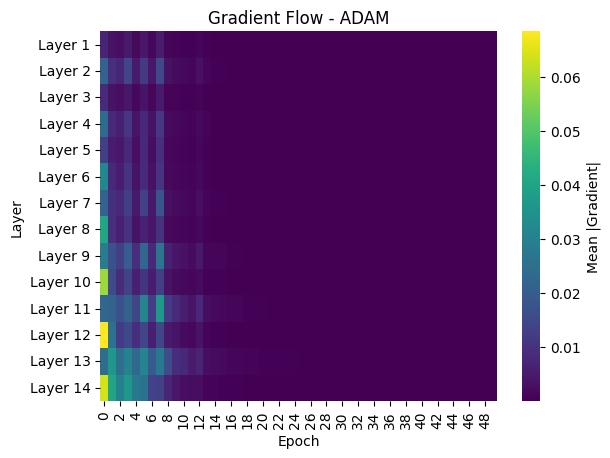

In [ ]:
# gradient 흐름
for name in grad_logs_all:
    epoch_grads = grad_logs_all[name]  # shape: (epochs, layers)
    epoch_grads_T = list(zip(*epoch_grads))  # transpose to (layers, epochs)

    df = pd.DataFrame(
        epoch_grads_T,
        index=[f'Layer {i+1}' for i in range(len(epoch_grads_T))]
    )

    sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Mean |Gradient|'})
    plt.title(f'Gradient Flow - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Layer')
    plt.show()


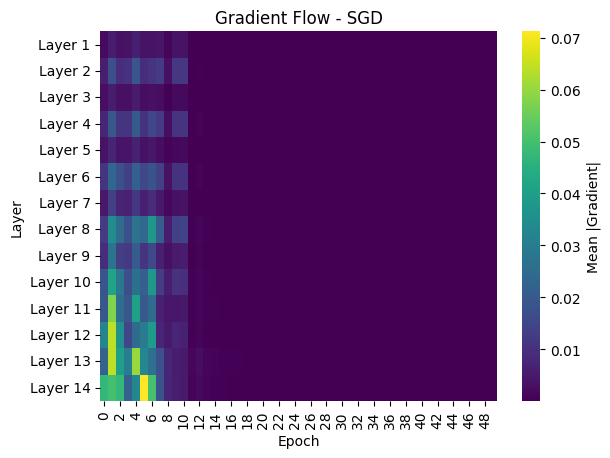

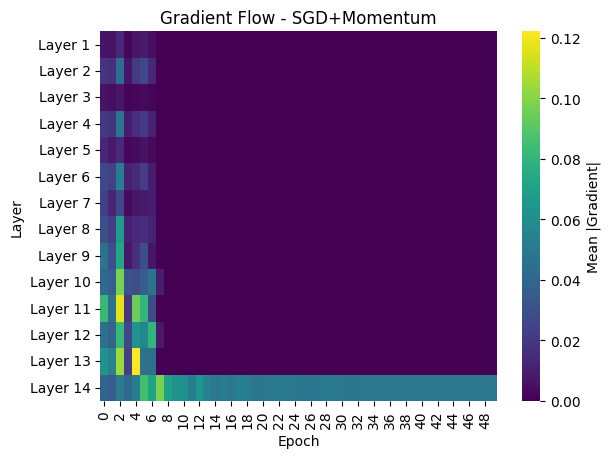

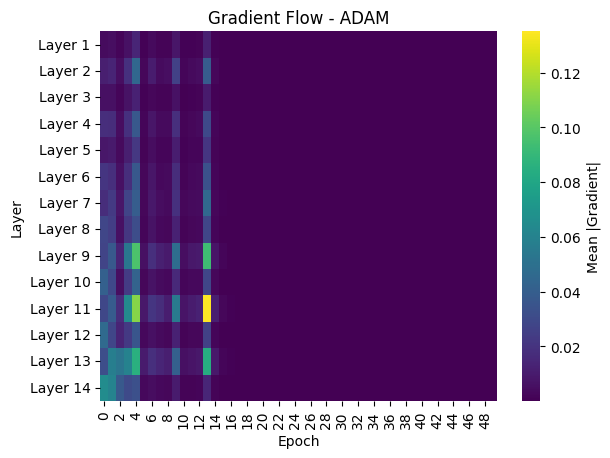

In [ ]:
# gradient 흐름 - no sched
for name in grad_logs_all_nosched:
    epoch_grads = grad_logs_all_nosched[name]  # shape: (epochs, layers)
    epoch_grads_T = list(zip(*epoch_grads))  # transpose to (layers, epochs)

    df = pd.DataFrame(
        epoch_grads_T,
        index=[f'Layer {i+1}' for i in range(len(epoch_grads_T))]
    )

    sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Mean |Gradient|'})
    plt.title(f'Gradient Flow - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Layer')
    plt.show()


In [ ]:
summary_data = []

# 안정성 측정

for use_scheduler in [True, False]:
    for name in opt_name:
        # 결과 선택
        res = result[name] if use_scheduler else result_nosched[name]

        summary_data.append({
            'Optimizer': name,
            'Use Scheduler': use_scheduler,
            'Train Loss': f"{res['train_loss'][-1]:.4f}",
            'Train Accuracy (%)': f"{res['train_accuracy'][-1]*100:.2f}",
            'Valid Loss': f"{res['valid_loss'][-1]:.4f}",
            'Valid Accuracy (%)': f"{res['valid_accuracy'][-1]*100:.2f}",
            'Convergence Epoch': res['convergence'],
            'Mean Gradient (Last Epoch)': f"{np.mean(grad_logs_all[name][-1]):.6f}",  # 마지막 에포킁에서의 평균 기울기 값
            'runtime' : res['runtime'],

        })


    # 🔻 여기에 한 줄 구분용 dummy row 삽입 -> True optimizer - True blank - False optimizer - False blank -> 마지막 행(False blank) 삭제
    summary_data.append({
        'Optimizer': '',
        'Use Scheduler': '',
        'Train Loss': '',
        'Train Accuracy (%)': '',
        'Valid Loss': '',
        'Valid Accuracy (%)': '',
        'Convergence Epoch': '',
        'runtime':'',
    })

# 마지막 빈 줄 제거 (스케줄러 기준 구분)
if summary_data and all(v == '' for v in summary_data[-1].values()):
    summary_data.pop()

pd.DataFrame(summary_data)


,Optimizer,Use Scheduler,Train Loss,Train Accuracy (%),Valid Loss,Valid Accuracy (%),Convergence Epoch,Mean Gradient (Last Epoch),runtime
0,SGD,True,0.0003,100.00,0.1628,97.14,19,0.000023,14.805093
1,SGD+Momentum,True,2.3023,9.81,2.3086,9.26,28,0.003455,15.419597
2,ADAM,True,0.0002,100.00,0.1941,96.97,22,0.000012,17.119998
3,,,,,,,,NaN,
4,SGD,False,0.0003,100.00,0.1152,96.97,22,0.000023,15.71
5,SGD+Momentum,False,2.3023,10.56,2.3086,9.26,25,0.003455,16.11
6,ADAM,False,0.0002,100.00,0.1933,97.31,25,0.000012,17.22


In [ ]:
summary_data = []

# 안정성: 평균 기울기(모든 에포크)와 손실 표준편차만 따로 출력
for use_scheduler in [True, False]:
    for name in opt_name:
        # 결과 선택
        res = result[name] if use_scheduler else result_nosched[name]

        summary_data.append({
            'Optimizer': name,
            'Use Scheduler': use_scheduler,
            'stability': [
                f"{compute_stability(res['valid_loss'], grad_logs)[1]:.6f}"
            ],
            'loss std': [
                f"{compute_stability(res['valid_loss'], grad_logs)[0]:.6f}"
            ]

        })


    # 🔻 여기에 한 줄 구분용 dummy row 삽입 -> True optimizer - True blank - False optimizer - False blank -> 마지막 행(False blank) 삭제
    summary_data.append({
        'Optimizer': '',
        'Use Scheduler': '',
        'stability':'',
        'loss std':''
    })

# 마지막 빈 줄 제거 (스케줄러 기준 구분)
if summary_data and all(v == '' for v in summary_data[-1].values()):
    summary_data.pop()

pd.DataFrame(summary_data)



,Optimizer,Use Scheduler,stability,loss std
0,SGD,True,[0.000025],[0.001549]
1,SGD+Momentum,True,[0.000025],[0.000030]
2,ADAM,True,[0.000025],[0.003260]
3,,,,
4,SGD,False,[0.000025],[0.000501]
5,SGD+Momentum,False,[0.000025],[0.000053]
6,ADAM,False,[0.000025],[0.001906]


In [ ]:
def visualize_activation_distribution_C(model, data, optimizer_label, epoch_tag="후반"):
    """
    실험 C (Optimizer 비교) - Layer 별 활성화 분포 시각화

    Parameters:
    - model: 학습된 tf.keras.Sequential 모델
    - data: 입력 데이터 (ex. test_X[:32])
    - optimizer_label: 예) 'SGD', 'SGD+Momentum', 'ADAM'
    - epoch_tag: '초기', '중간', '후반' 등 학습 시점 설명
    """
    x = data
    activations = []

    for i, layer in enumerate(model.layers[:-1]):  # 마지막 출력층 제외
        x = layer(x)
        activations.append(x.numpy().flatten())

    # 시각화
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 4))
    for i, act in enumerate(activations):
        plt.subplot(1, len(activations), i+1)
        plt.hist(act, bins=30)
        plt.title(f"{optimizer_label} - {epoch_tag} - Layer {i+1}")
        plt.xlabel("Activation")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


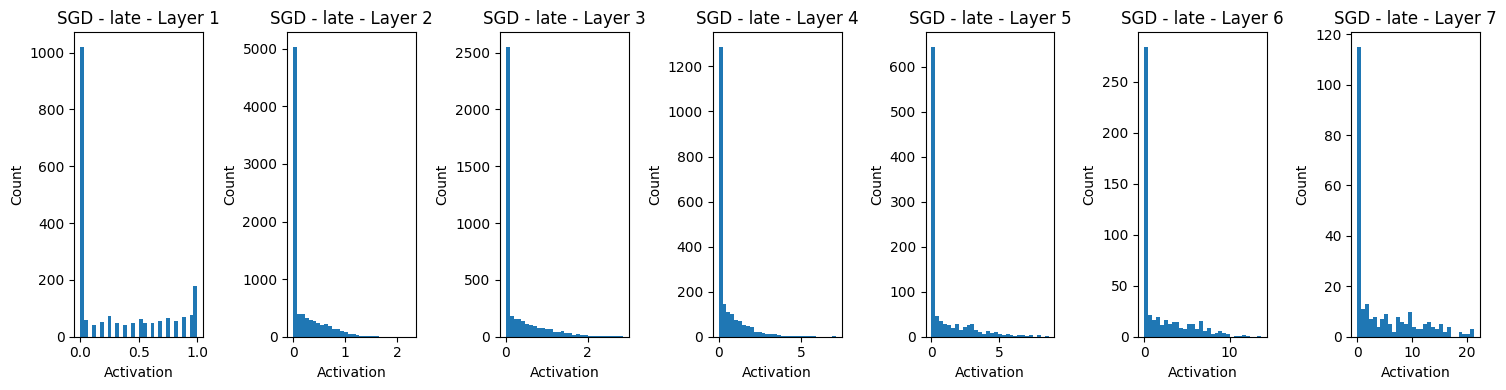

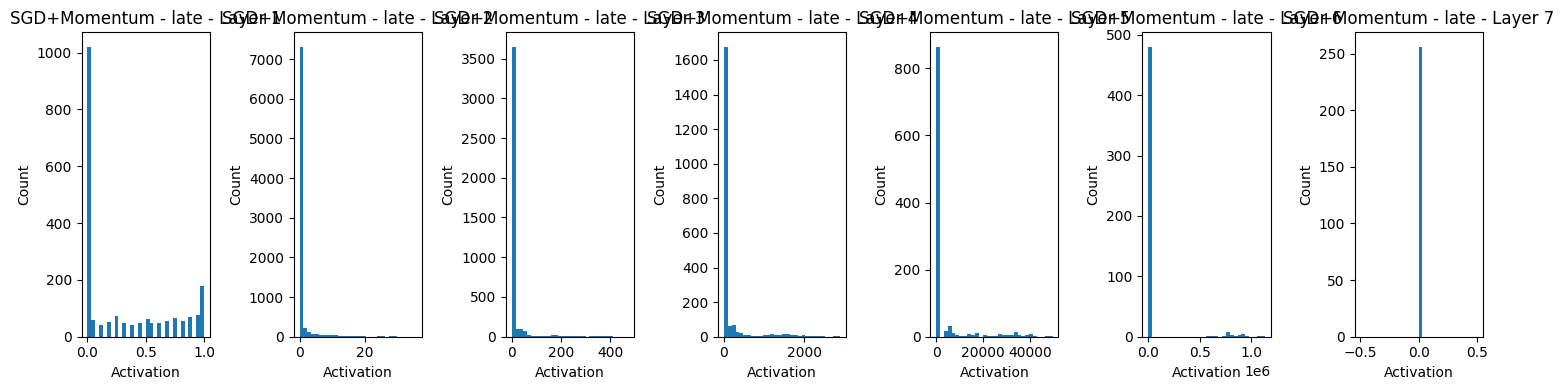

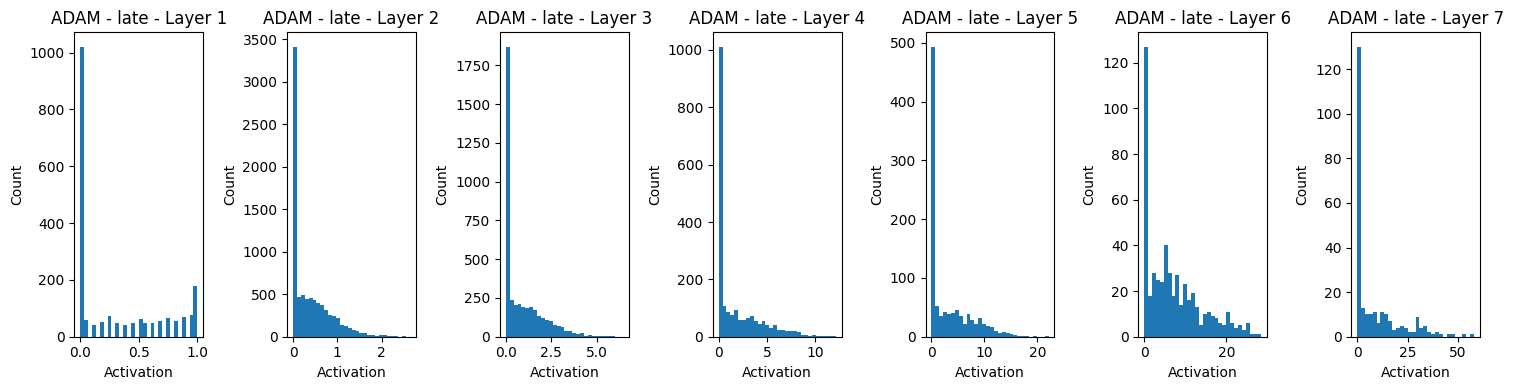

In [ ]:
# test_X는 Tensor이며 배치 사이즈 제한
visualize_activation_distribution_C(result['SGD']['model'], test_X[:32], optimizer_label='SGD', epoch_tag='late')
visualize_activation_distribution_C(result['SGD+Momentum']['model'], test_X[:32], optimizer_label='SGD+Momentum', epoch_tag='late')
visualize_activation_distribution_C(result['ADAM']['model'], test_X[:32], optimizer_label='ADAM', epoch_tag='late')
